In [1]:
# Standard Library Imports
from collections import Counter
from tabnanny import verbose

# Third-Party Libraries
import shap
from upsetplot import from_memberships, plot
from scipy.stats import chi2_contingency, f_oneway
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# scikit-learn Imports
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import umap


In [2]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/Measles/antibody_df.csv')

# Load the cytokines data
cytokines = pd.read_csv('../data/Measles/cytokines_data.csv')

# Load the cytometry data
cytometry = pd.read_csv('../data/Measles/cyto_data.csv')


Frequency of responses:
response_label
no response    29
response       11
Name: count, dtype: int64


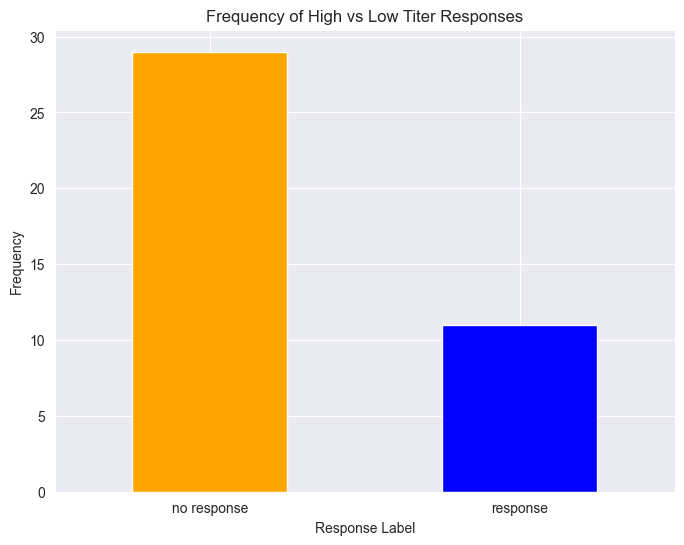

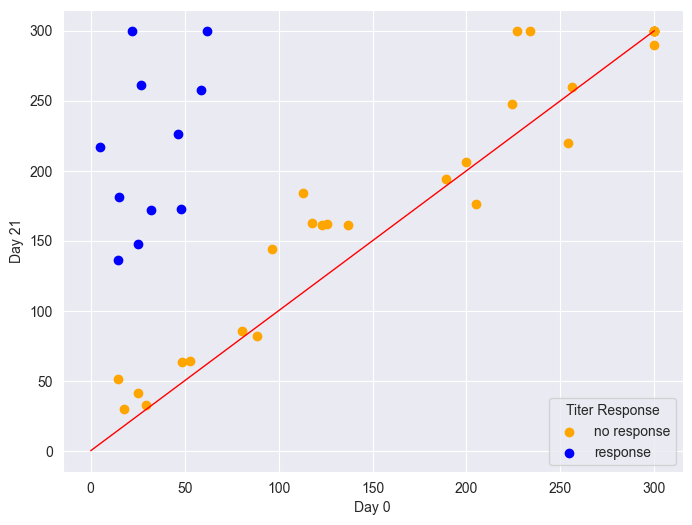

In [3]:
# Count the frequency of each label
abtiters['response_label'] = abtiters['quadrant'].apply(lambda x: 'response' if x == 'responder' else 'no response')

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

colors = {'response': 'blue', 'no response': 'orange'}
plt.figure(figsize=(8, 6))
for label, group in abtiters.groupby('response_label'):
    plt.scatter(group['Day 0'], group['Day 21'], color=colors[label], label=label)

# Plot reference line y = x
plt.plot([0, max(abtiters['Day 0'])], [0, max(abtiters['Day 21'])], color='red', linestyle='-', linewidth=1)

# Labeling and legend
plt.xlabel('Day 0')
plt.ylabel('Day 21')
plt.legend(title="Titer Response")
plt.show()

In [4]:
abtiters = abtiters.drop(columns=['vaccine', 'Day 0', 'Day 21', 'Day 150', 'Day 365', 'diff: 21-0', 'diff: 150-21', 'diff: 365-150', 'response', 'protected','quadrant'])
print(abtiters.head())

## abtiters already loaded ##
## cytokines already loaded ##
cytometry = cytometry[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']] # already loaded


metadata = pd.read_csv('../data/Measles/metadata.csv')

gender_mapping = {'M': 1, 'F': 0}
metadata['Gender'] = metadata['Gender'].map(gender_mapping)

  Vaccinee response_label
0       M1       response
1      M11    no response
2      M12    no response
3      M13    no response
4      M14       response


In [5]:
cytokines_cyto = pd.merge(cytokines, cytometry, on='Vaccinee')
merged = pd.merge(cytokines_cyto, metadata, on='Vaccinee')
merged_data = pd.merge(abtiters, merged, on='Vaccinee')

# Separate features and response labels
X = merged_data.drop(columns=['response_label', 'Vaccinee'])
y = merged_data['response_label']

In [6]:
def _add_reference_circles(ax, radii=[0.5, 1.0], color='gray', linestyle='--', linewidth=0.8, alpha=0.5):
    for radius in radii:
        circle = plt.Circle((0, 0), radius, color=color, fill=False, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
        ax.add_artist(circle)

def plot_pls_with_response_marginals(
    data, 
    numeric_features=None, 
    response_label_col='response_label', 
    excluded_features=[],
    pc1_err_col=None, 
    pc2_err_col=None,
    percentile=90,
    n_components=2,
    verbose=False,
    exclude_outliers = False
):
    """
    Plots a PLS scatter plot with marginal boxplots grouped by response labels,
    and includes a biplot with feature contributions based on loadings.
    """
    # Select numeric features for PLS
    if numeric_features is None:
        numeric_features = data.select_dtypes(include=[float, int]).columns.tolist()
        excluded_columns = [response_label_col] + excluded_features
        numeric_features = [col for col in numeric_features if col not in excluded_columns]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[numeric_features])
    
    # Encode the target variable if it's categorical
    if data[response_label_col].dtype == 'object' or data[response_label_col].dtype.name == 'category':
        le = LabelEncoder()
        y = le.fit_transform(data[response_label_col])
        print(dict(zip(le.classes_, le.transform(le.classes_))))
    else:
        y = data[response_label_col].values

    # Perform PLS Regression
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, y)
    
    # Transform the data
    X_pls = pls.transform(X_scaled)
    data[f'Component1'] = X_pls[:, 0]
    data[f'Component2'] = X_pls[:, 1]
    
    # Extract Y scores (latent variables for Y)
    Y_pls = pls.y_scores_
    
    # Calculate Pearson correlation for each component pair
    corr1, _ = pearsonr(pls.x_scores_[:, 0], Y_pls[:, 0])
    corr2, _ = pearsonr(pls.x_scores_[:, 1], Y_pls[:, 1])
    
    print(f"X-Y Variates 1 Correlation: {corr1:.2f}")
    print(f"X-Y Variates 2 Correlation: {corr2:.2f}")
    
    # Extract and scale loadings
    loadings = pls.x_weights_
    norms = np.linalg.norm(loadings, axis=1)
    max_norm = norms.max()
    scaled_loadings = loadings / max_norm
    
    # Feature selection based on percentile for Component1 and Component2
    loadings_component1 = np.abs(pls.x_weights_[:, 0])
    threshold_component1 = np.percentile(loadings_component1, percentile)
    top_features_component1 = data[numeric_features].columns[loadings_component1 >= threshold_component1]
    
    loadings_component2 = np.abs(pls.x_weights_[:, 1])
    threshold_component2 = np.percentile(loadings_component2, percentile)
    top_features_component2 = data[numeric_features].columns[loadings_component2 >= threshold_component2]
    
    if verbose:
        print(f"\nTop Features Contributing to Component1 (Top {100 - percentile}%):")
        print(top_features_component1.tolist())
        print(f"Loading threshold at the {percentile}th percentile: {threshold_component1:.4f}")
        
        print(f"\nTop Features Contributing to Component2 (Top {100 - percentile}%):")
        print(top_features_component2.tolist())
        print(f"Loading threshold at the {percentile}th percentile: {threshold_component2:.4f}")
    
    # Create the plot
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(2, 2, width_ratios=(7, 2), height_ratios=(2, 7), wspace=0.05, hspace=0.05)
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
    
    # Scatter plot grouped by response labels
    scatter_kwargs = {
        'data': data, 
        'x': 'Component1', 
        'y': 'Component2', 
        'ax': ax_scatter, 
        'alpha': 0.7,
        'hue': response_label_col
    }
    sns.scatterplot(**scatter_kwargs)

    # Plot feature vectors (biplot arrows)
    for i, feature in enumerate(numeric_features):
        ax_scatter.scatter(
            scaled_loadings[i, 0], scaled_loadings[i, 1], 
            color='red', alpha=0.8, marker='s', s=20, label=feature if i == 0 else ""
        )
        # Scale the distance for the text positions
        ax_scatter.text(
            scaled_loadings[i, 0], scaled_loadings[i, 1],  
            feature, color='black', ha='center', va='center', fontsize=9
        )
        
    # Add reference circles to indicate feature contribution thresholds
    _add_reference_circles(
        ax_scatter, 
        radii=[0.5, 1.0], 
        color='gray', 
        linestyle='--', 
        linewidth=0.8, 
        alpha=0.7
    )
    ax_scatter.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax_scatter.axvline(0, color='gray', linewidth=0.8, linestyle='--')

    # Adding error bars if specified
    if pc1_err_col and pc2_err_col:
        ax_scatter.errorbar(
            data['Component1'], data['Component2'],
            xerr=data[pc1_err_col], yerr=data[pc2_err_col],
            fmt='none', ecolor='gray', alpha=0.5
        )

    # Marginal boxplots grouped by response labels
    sns.boxplot(
        data=data, 
        x='Component1', 
        y=response_label_col, 
        orient='h', 
        ax=ax_hist_x, 
        hue=response_label_col,  
        palette="Set2", 
        dodge=False  
    )
    sns.boxplot(
        data=data, 
        x=response_label_col, 
        y='Component2', 
        orient='v', 
        ax=ax_hist_y, 
        hue=response_label_col,  
        palette="Set2", 
        dodge=False  
    )

    # Hide labels on marginal plots for cleaner visualization
    ax_hist_x.tick_params(axis='x', labelbottom=False)
    ax_hist_y.tick_params(axis='y', labelleft=False)

    # Adjust subplot visibility
    for spine in ['top', 'right', 'left']:
        ax_hist_x.spines[spine].set_visible(False)
    for spine in ['top', 'right', 'bottom']:
        ax_hist_y.spines[spine].set_visible(False)

    # Axis labels and title
    ax_scatter.set_xlabel(f"X-Y Variates 1 Correlation: {corr1*100:.0f}%")
    ax_scatter.set_ylabel(f"X-Y Variates 2 Correlation: {corr2*100:.0f}%")
    ax_scatter.set_title("PLS Scatter Plot with Feature Biplot")

    plt.show()
    
def plot_pls_only_contributions(
    data, 
    numeric_features=None, 
    response_label_col='response_label', 
    excluded_features=[],
    n_components=2,
):
    """
    Plots a single PLS scatter plot with feature contributions and reference circles.
    """
    # Select numeric features for PLS
    if numeric_features is None:
        numeric_features = data.select_dtypes(include=[float, int]).columns.tolist()
        excluded_columns = [response_label_col] + excluded_features
        numeric_features = [col for col in numeric_features if col not in excluded_columns]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[numeric_features])
    
    # Encode the target variable if it's categorical
    if data[response_label_col].dtype == 'object' or data[response_label_col].dtype.name == 'category':
        le = LabelEncoder()
        y = le.fit_transform(data[response_label_col])
    else:
        y = data[response_label_col].values

    # Perform PLS Regression
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, y)
    
    # Transform the data
    X_pls = pls.transform(X_scaled)
    data[f'Component1'] = X_pls[:, 0]
    data[f'Component2'] = X_pls[:, 1]
    
    # Extract Y scores (latent variables for Y)
    Y_pls = pls.y_scores_
    
    # Calculate Pearson correlation for each component pair
    corr1, _ = pearsonr(pls.x_scores_[:, 0], Y_pls[:, 0])
    corr2, _ = pearsonr(pls.x_scores_[:, 1], Y_pls[:, 1])

    # Extract and scale loadings
    loadings = pls.x_weights_
    norms = np.linalg.norm(loadings, axis=1)
    max_norm = norms.max()
    scaled_loadings = loadings / max_norm
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 20))

    # Plot feature vectors (biplot arrows)
    for i, feature in enumerate(numeric_features):
        ax.scatter(
            scaled_loadings[i, 0], scaled_loadings[i, 1], 
            color='red', alpha=0.8, marker='s', s=20, label=feature if i == 0 else ""
        )
        # Scale the distance for the text positions
        ax.text(
            scaled_loadings[i, 0], scaled_loadings[i, 1],  
            feature, color='black', ha='center', va='center', fontsize=9
        )
        
    # Add reference circles to indicate feature contribution thresholds
    _add_reference_circles(
        ax, 
        radii=[0.5, 1.0], 
        color='gray', 
        linestyle='--', 
        linewidth=0.8, 
        alpha=0.7
    )
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.8, linestyle='--')

    # Axis labels and title
    ax.set_xlabel(f"X-Y Variates 1 Correlation: {corr1*100:.0f}%")
    ax.set_ylabel(f"X-Y Variates 2 Correlation: {corr2*100:.0f}%")
    ax.set_title("PLS Scatter Plot with Feature Biplot")

    plt.show()
    

In [7]:
def _add_reference_circles(ax, radii=[0.5, 1.0], color='gray', linestyle='--', linewidth=0.8, alpha=0.5):
    for radius in radii:
        circle = plt.Circle((0, 0), radius, color=color, fill=False, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
        ax.add_artist(circle)

def plot_pca_with_response_marginals(
    data, 
    numeric_features=None, 
    response_label_col='response_label', 
    excluded_features=[],
    pc1_err_col=None, 
    pc2_err_col=None,
    verbose = False
):
    """
    Plots a PCA scatter plot with marginal boxplots grouped by response and non-response labels,
    and includes a biplot with feature contributions.
    """
    loadings = None
    
    # Select numeric features for PCA
    if numeric_features is None:
        numeric_features = data.select_dtypes(include=[float, int]).columns.tolist()
        excluded_columns = [response_label_col, 'Vaccinee']
        excluded_columns.extend(excluded_features)
        numeric_features = [col for col in numeric_features if col not in excluded_columns]

    # Perform PCA if PC1 and PC2 do not exist
    if 'PC1' not in data.columns or 'PC2' not in data.columns:
        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(data[numeric_features])
        
        # Perform PCA
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X_scaled)
        data['PC1'] = principal_components[:, 0]
        data['PC2'] = principal_components[:, 1]
        
        # Identify top features contributing to each PCA component
        if verbose: print("\nFeature Contributions to PCA Components:")
        for i in range(2):  # For the first 2 components
            component_features = sorted(
                zip(numeric_features, pca.components_[i]),
                key=lambda x: abs(x[1]), 
                reverse=True
            )
            if verbose:
                print(f"Top features in PCA Component {i+1}:")
                for feature, loading in component_features:
                    print(f"  {feature}: {loading:.4f}")

        # Store PCA loadings for biplot
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Create the plot
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(2, 2, width_ratios=(7, 2), height_ratios=(2, 7), wspace=0.05, hspace=0.05)
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

    # Scatter plot grouped by response labels
    scatter_kwargs = {'data': data, 'x': 'PC1', 'y': 'PC2', 'ax': ax_scatter, 'alpha': 0.7}
    scatter_kwargs['hue'] = response_label_col
    sns.scatterplot(**scatter_kwargs)
    
    visual_multiplier = 3

    # Plot feature vectors (biplot arrows)
    for i, feature in enumerate(numeric_features):
        ax_scatter.scatter(
            loadings[i, 0] * visual_multiplier, loadings[i, 1] * visual_multiplier,  # Scale positions by 2
            color='red', alpha=0.8, marker='s', s=20, label=feature if i == 0 else ""  # Reduced size
        )
        # Scale the distance for the text positions
        ax_scatter.text(
            loadings[i, 0] * (visual_multiplier + 0.2), loadings[i, 1] * (visual_multiplier + 0.2),  # Scale positions by 2.2 for separation
            feature, color='black', ha='center', va='center', fontsize=9
        )
        
    # Add reference circles to indicate feature contribution thresholds
    _add_reference_circles(ax_scatter, radii=[0.5*visual_multiplier, 1.0*visual_multiplier], color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
    ax_scatter.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    ax_scatter.axvline(0, color='gray', linewidth=0.8, linestyle='--')

    # Adding error bars if specified
    if pc1_err_col and pc2_err_col:
        ax_scatter.errorbar(
            data['PC1'], data['PC2'],
            xerr=data[pc1_err_col], yerr=data[pc2_err_col],
            fmt='none', ecolor='gray', alpha=0.5
        )

    # Marginal boxplots grouped by response labels
    sns.boxplot(
        data=data, 
        x='PC1', 
        y=response_label_col, 
        orient='h', 
        ax=ax_hist_x, 
        hue=response_label_col, # Assign hue to the response label
        palette="Set2", 
        dodge=False  # Ensures only one box per response_label
    )
    sns.boxplot(
        data=data, 
        x=response_label_col, 
        y='PC2', 
        orient='v', 
        ax=ax_hist_y, 
        hue=response_label_col,  # Assign hue to the response label
        palette="Set2", 
        dodge=False  # Ensures only one box per response_label
    )

    # Hide labels on marginal plots for cleaner visualization
    ax_hist_x.tick_params(axis='x', labelbottom=False)
    ax_hist_y.tick_params(axis='y', labelleft=False)

    # Adjust subplot visibility
    ax_hist_x.spines['top'].set_visible(False)
    ax_hist_x.spines['right'].set_visible(False)
    ax_hist_x.spines['left'].set_visible(False)
    ax_hist_y.spines['top'].set_visible(False)
    ax_hist_y.spines['right'].set_visible(False)
    ax_hist_y.spines['bottom'].set_visible(False)

    # Axis labels and title
    ax_scatter.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}%)")
    ax_scatter.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}%)")
    ax_scatter.set_title("PCA Scatter Plot with Feature Biplot")

    plt.show()

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'GCSF', 'Flt3 Ligand', 'GM-CSF', 'Fractalkine', 'IFNa2', 'IFNg', 'GRO',
       'IL-10', 'MCP3', 'IL12-p40', 'MDC', 'IL12-p70', 'IL-13', 'IL-15',
       'sCD40L', 'IL17A', 'IL1Ra', 'IL1a', 'IL-9', 'IL-1b', 'IL-2', 'IL-5',
       'IL-6', 'IL-7', 'IL-8', 'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa',
       'TNFb', 'VEGF', 'WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0',
       'PLT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')
{'no response': np.int64(0), 'response': np.int64(1)}
X-Y Variates 1 Correlation: 0.49
X-Y Variates 2 Correlation: 0.57

Top Features Contributing to Component1 (Top 10%):
['HHV6.Status', 'IL-9', 'IL-8', 'HGB Day 0', '%LYM Day 0']
Loading threshold at the 90th percentile: 0.2039

Top Features Contributing to Component2 (Top 10%):
['FGF-2', 'TGF-a', 'TNFa', 'VEGF', '%MON Day 0']

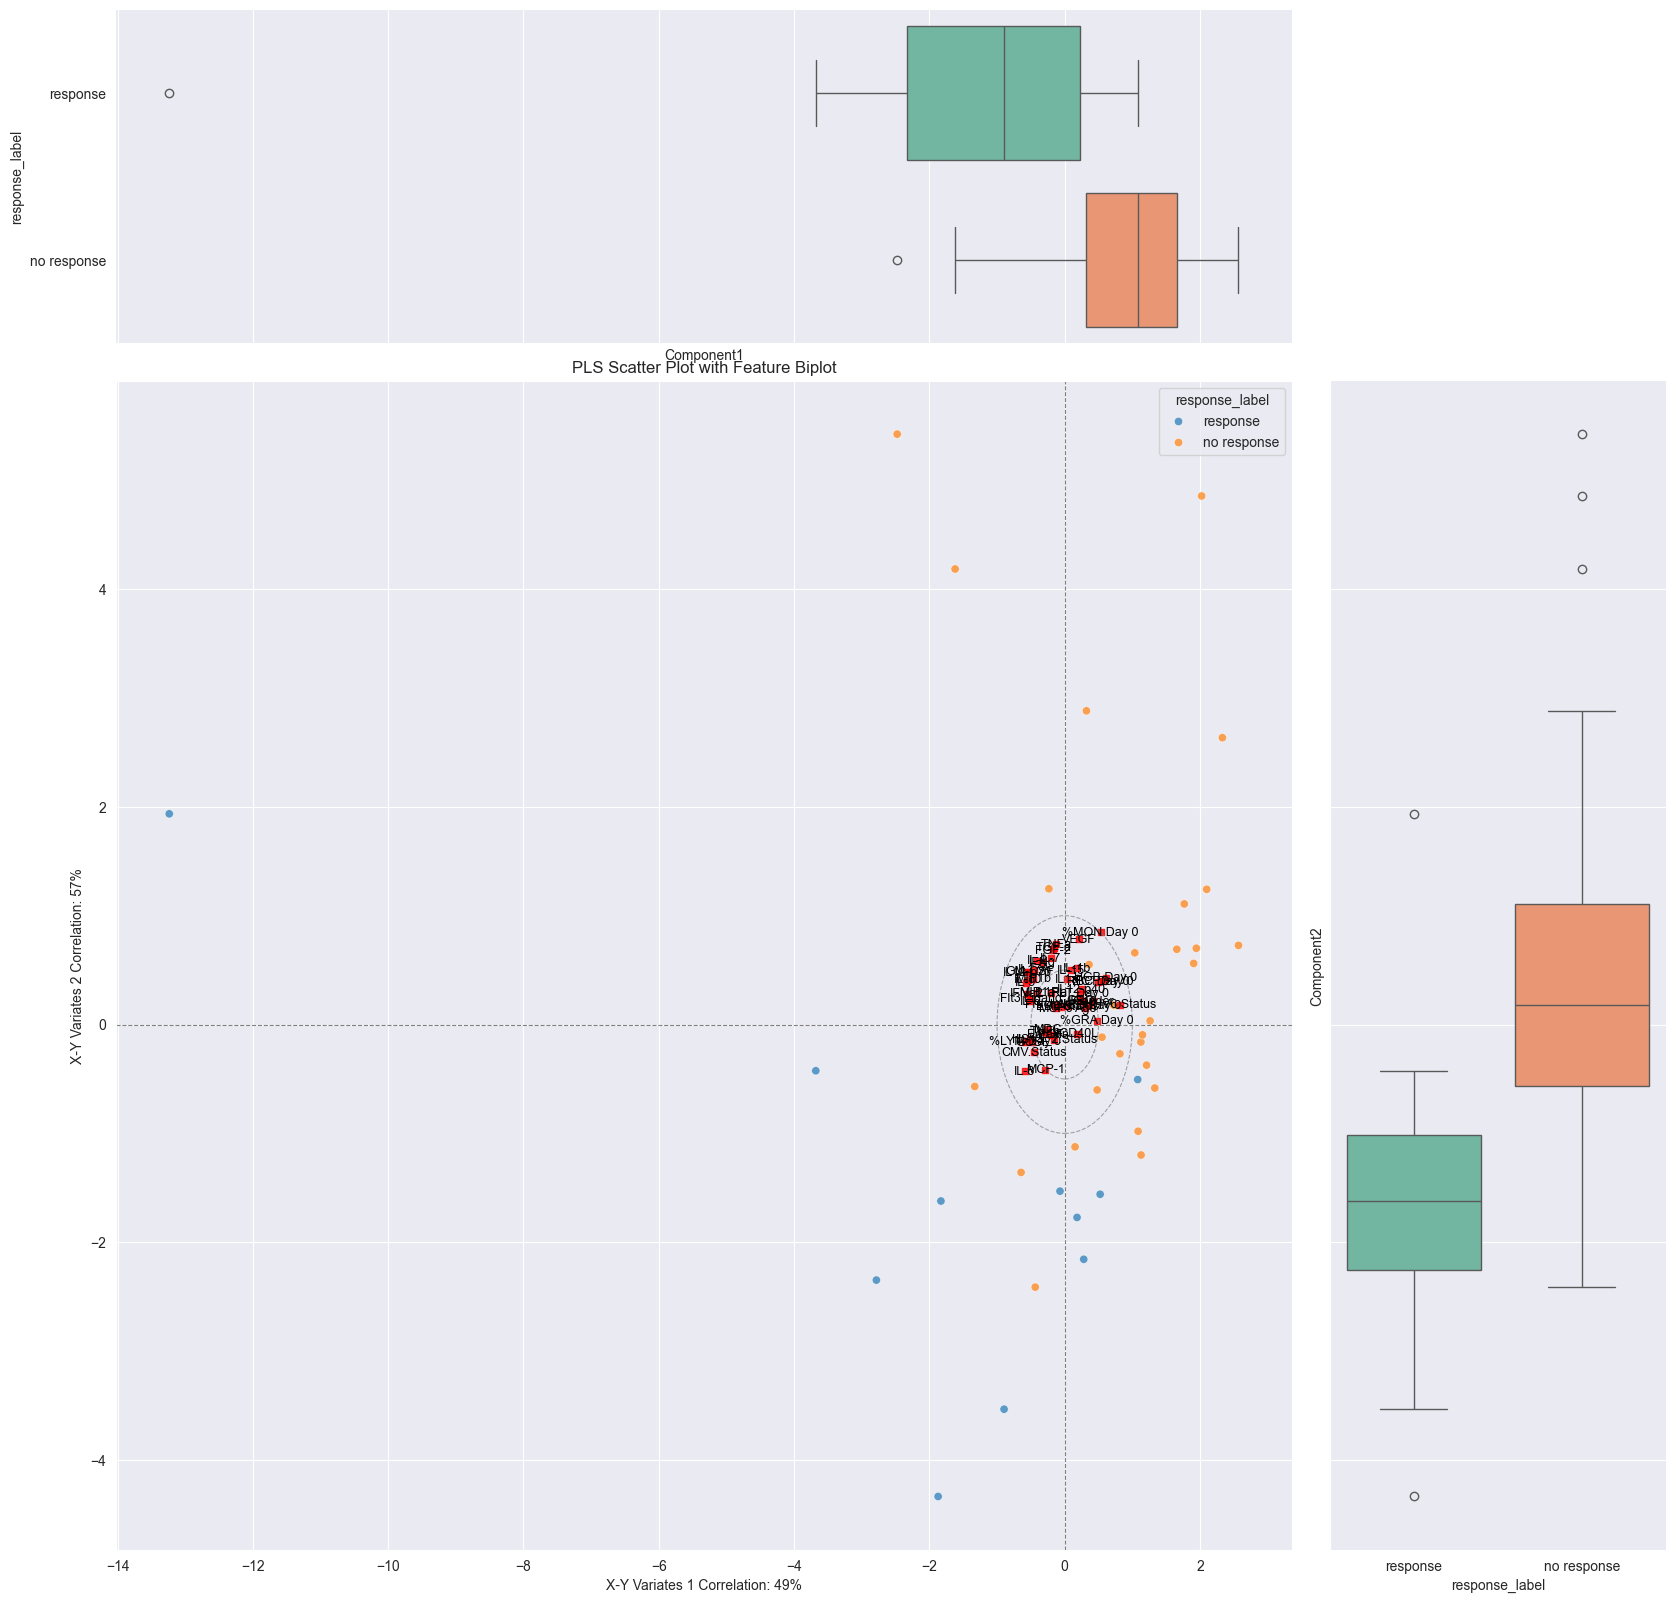

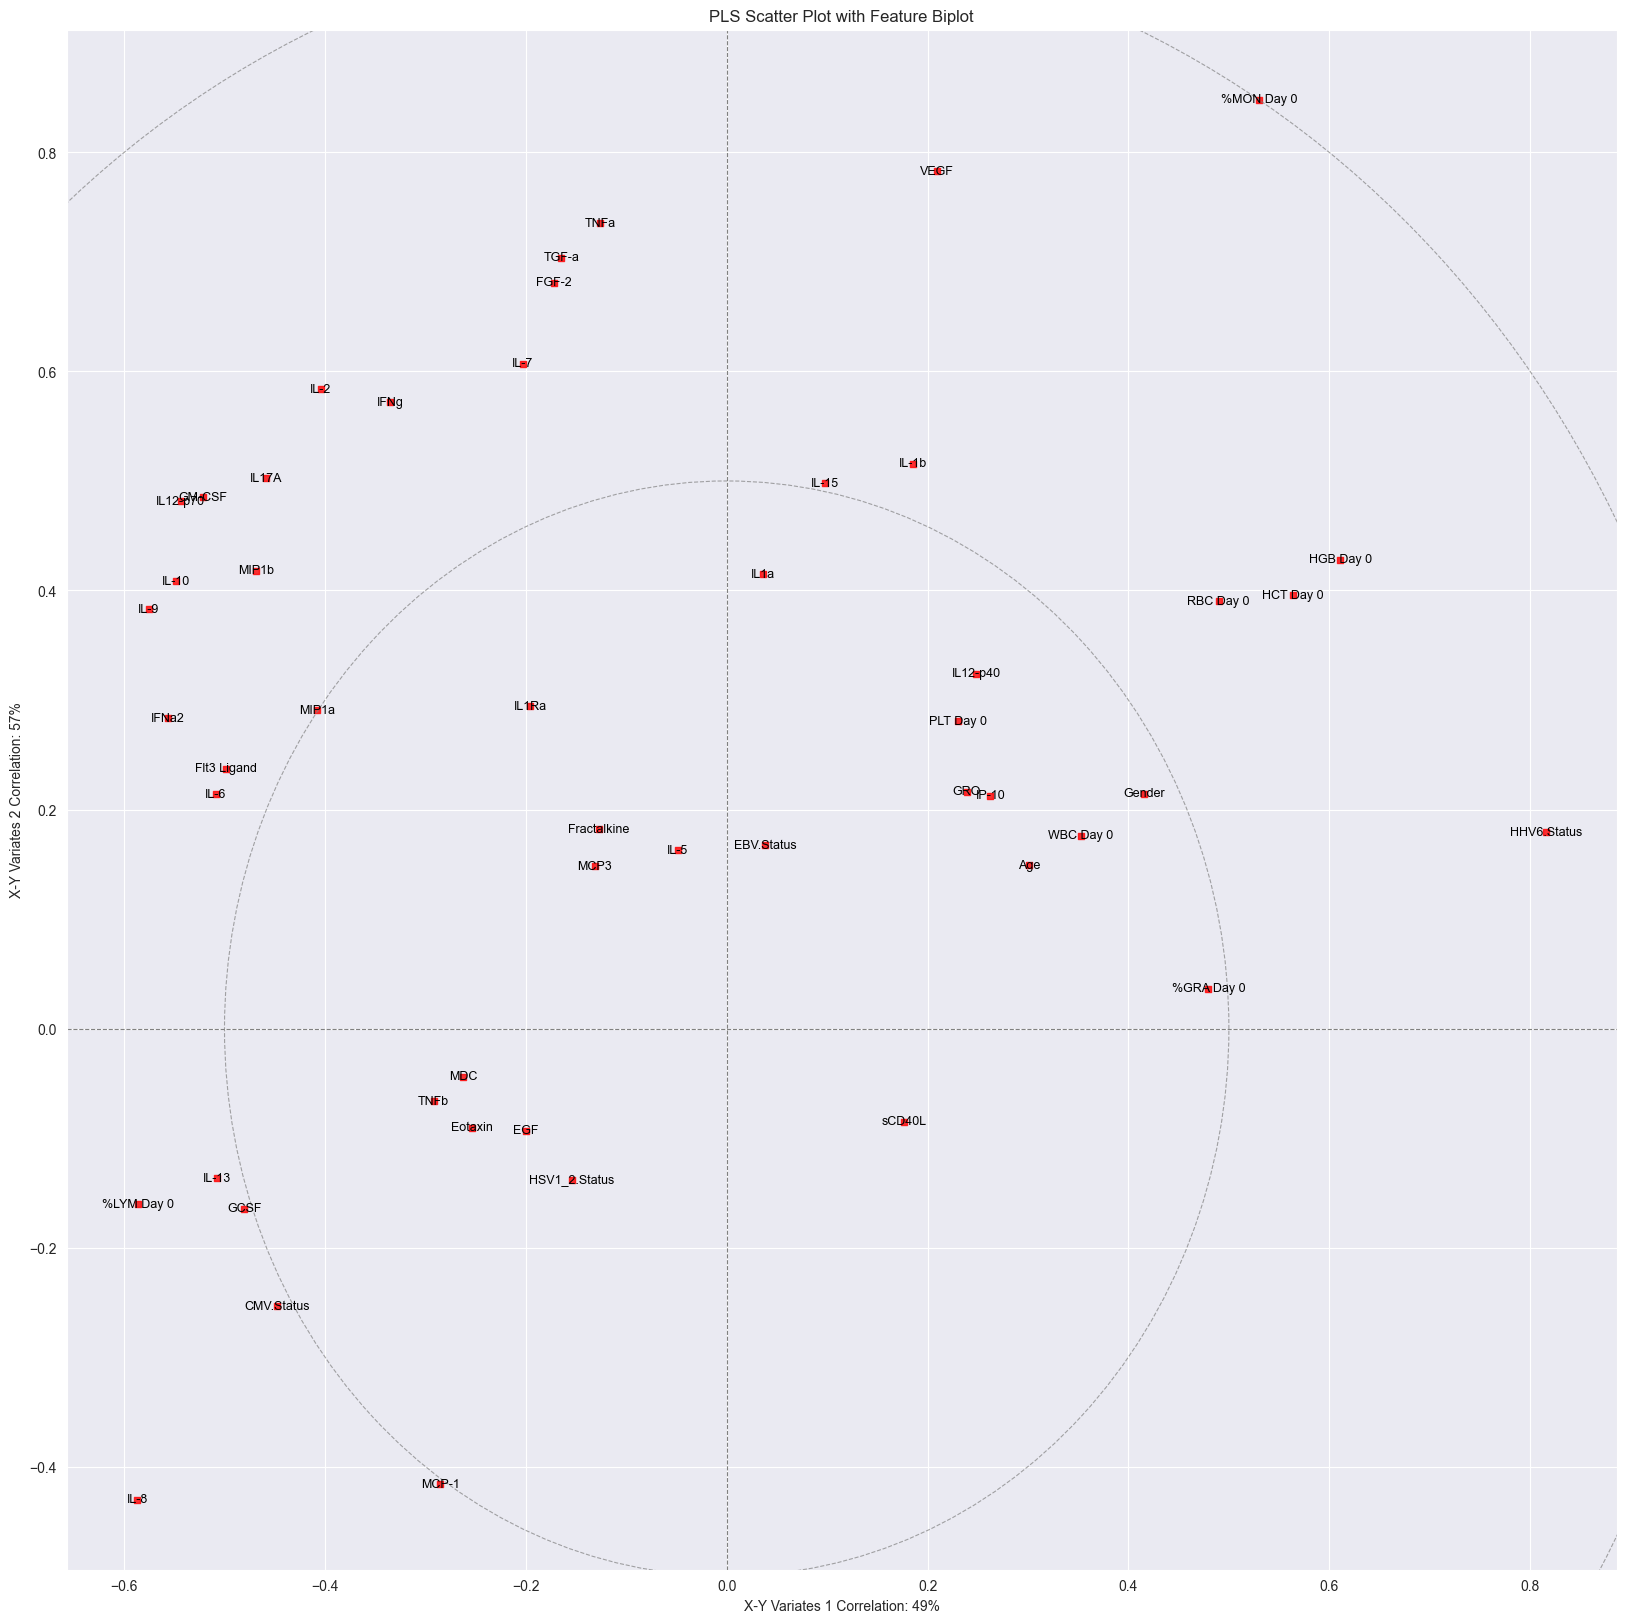

In [8]:
print(merged_data.columns)
plot_pls_with_response_marginals(
    data=merged_data.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    pc1_err_col=None,
    pc2_err_col=None,
    verbose=True,
)

# plot the same but without outliers so we can see feature comtributions better
plot_pls_only_contributions(
    data=merged_data.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
)

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'Flt3 Ligand', 'IFNg', 'GRO', 'MDC', 'sCD40L', 'IL17A', 'IL1Ra', 'IL-8',
       'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa', 'VEGF', 'WBC Day 0',
       'RBC Day 0', 'HGB Day 0', 'HCT Day 0', 'PLT Day 0', '%LYM Day 0',
       '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')
{'no response': np.int64(0), 'response': np.int64(1)}
X-Y Variates 1 Correlation: 0.56
X-Y Variates 2 Correlation: 0.48

Top Features Contributing to Component1 (Top 10%):
['HHV6.Status', 'IL-8', 'HGB Day 0', '%LYM Day 0']
Loading threshold at the 90th percentile: 0.2616

Top Features Contributing to Component2 (Top 10%):
['FGF-2', 'TNFa', 'VEGF', '%MON Day 0']
Loading threshold at the 90th percentile: 0.3194


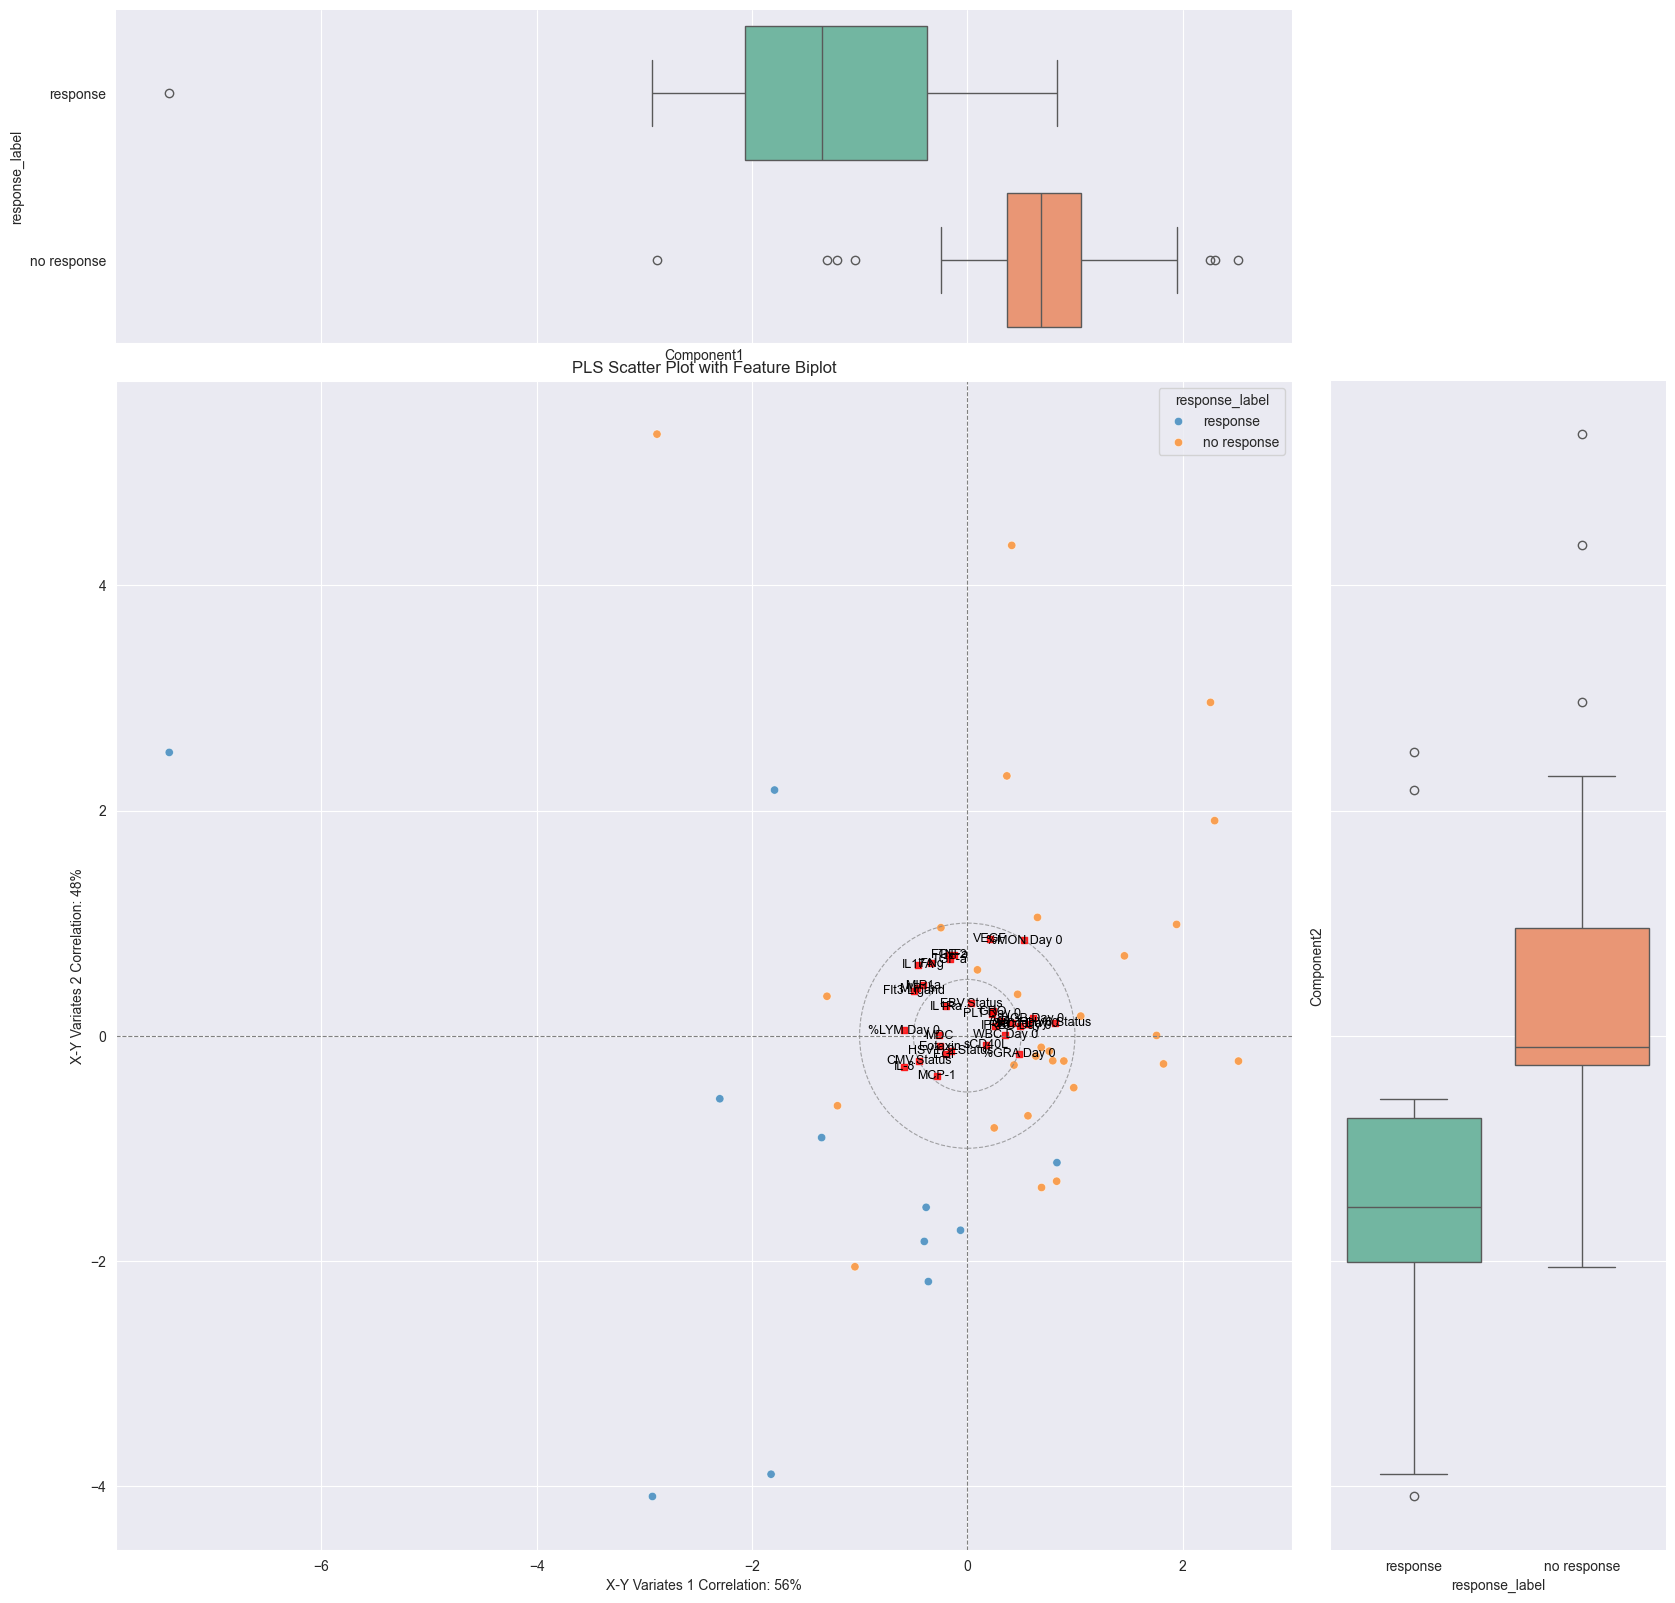

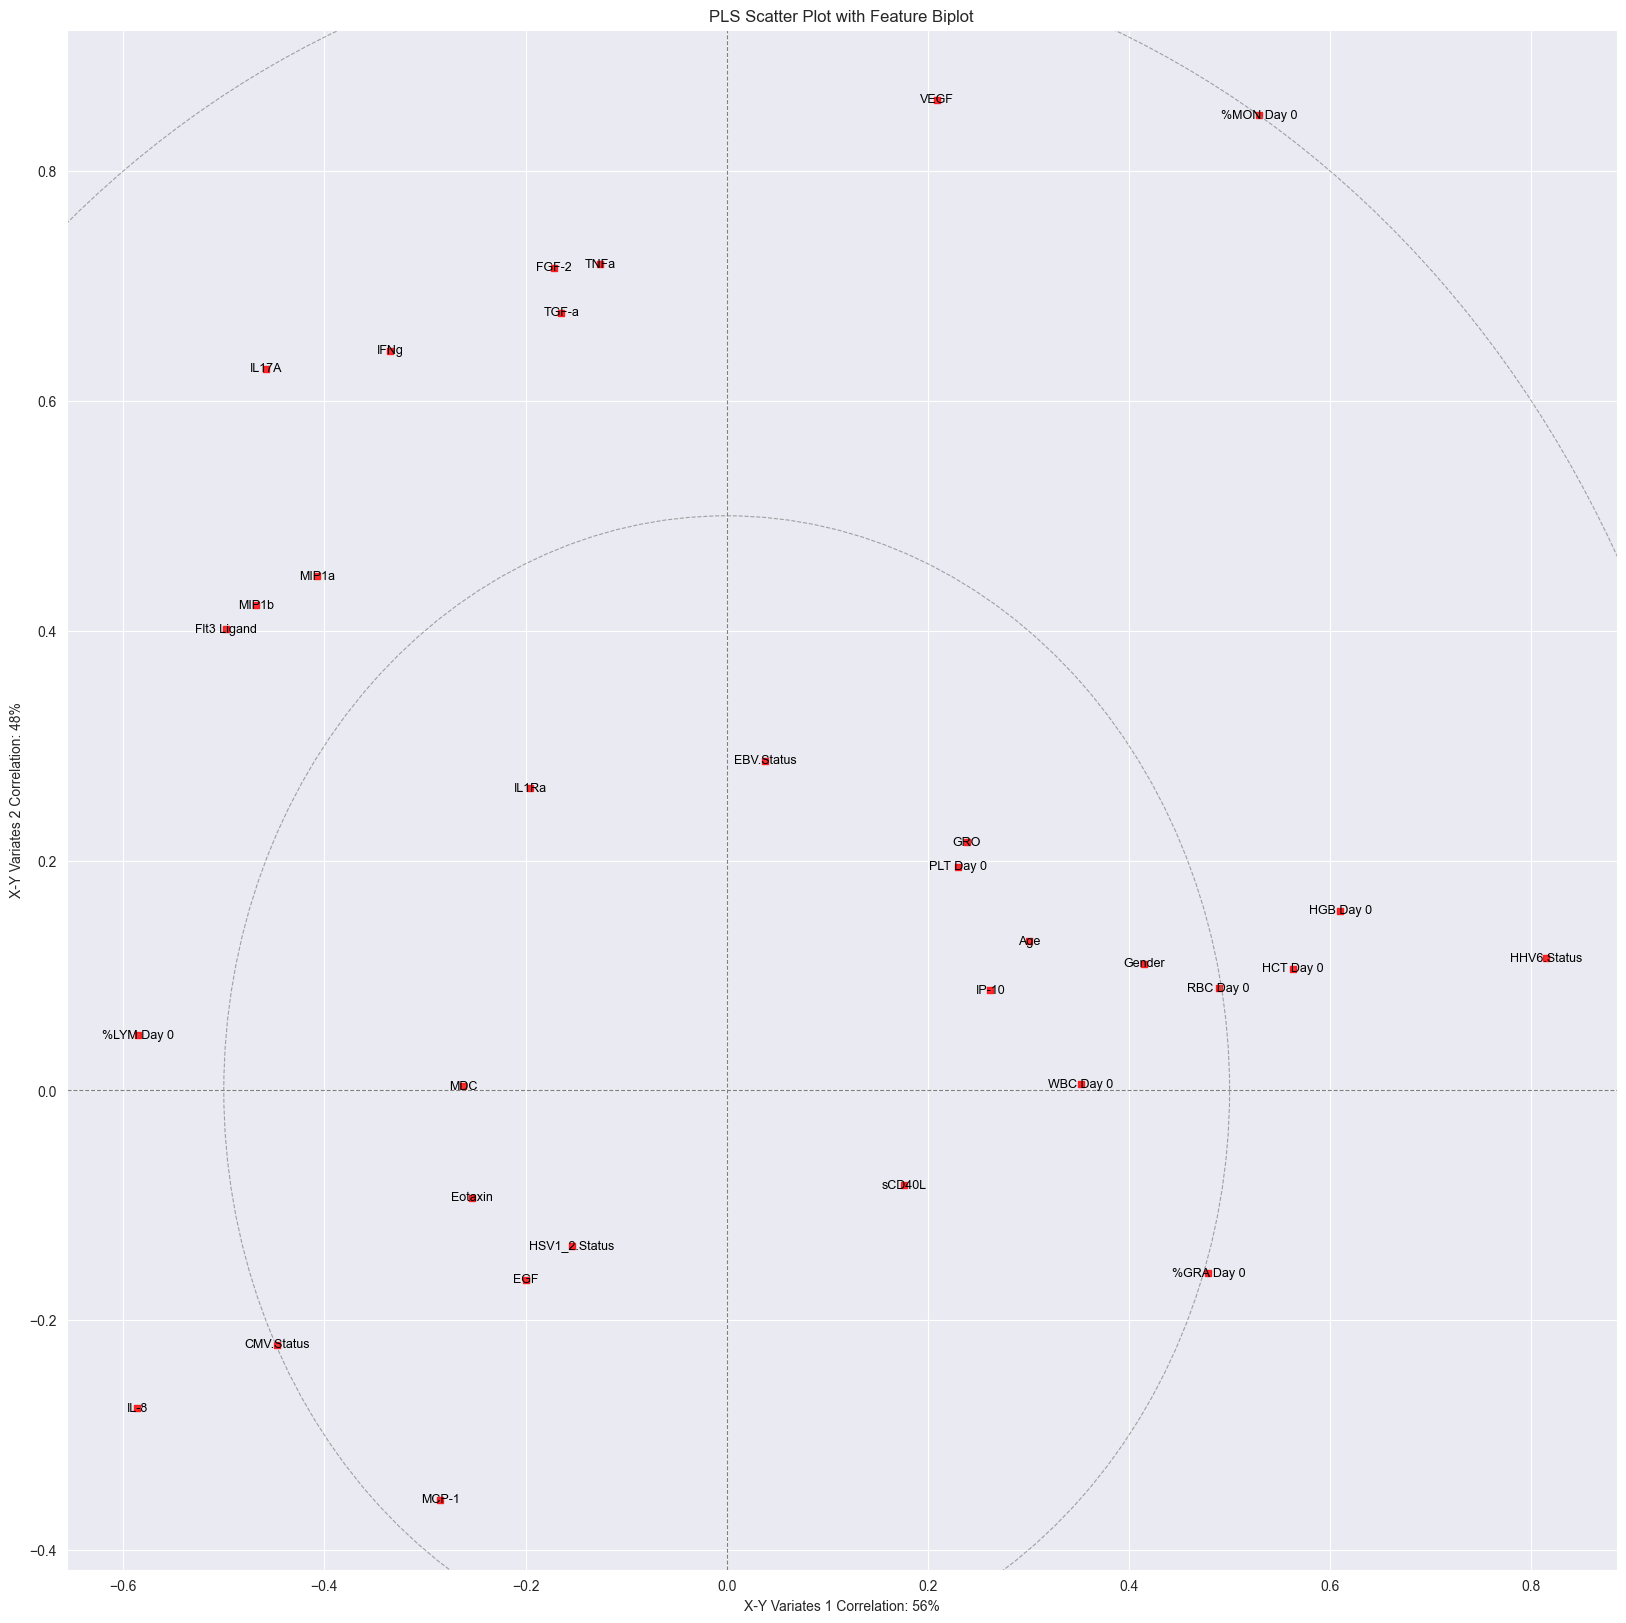

In [9]:
# Cytokines that don't deviate from the limit of detection
cytokines_to_remove = [
    "GCSF",
    "GM-CSF",
    "Fractalkine",
    "IFNa2",
    "IL-10",
    "MCP3",
    "IL12-p40",
    "IL12-p70",
    "IL-13",
    "IL-15",
    "IL1a",
    "IL-9",
    "IL-1b",
    "IL-2",
    # "IL-3", i don't have these
    # "IL-4", i don't have these
    "IL-5",
    "IL-6",
    "IL-7",
    "TNFb"
]


# Prepare your data
merged_data_less_cytokines = merged_data.drop(columns=cytokines_to_remove)

print(merged_data_less_cytokines.columns)
plot_pls_with_response_marginals(
    data=merged_data_less_cytokines.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    pc1_err_col=None,
    pc2_err_col=None,
    verbose=True,
)

plot_pls_only_contributions(
    data=merged_data_less_cytokines.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
)

In [10]:
# looking at correlation_heatmap_merged_ward2.png
# if filter_out_cytokines_to_remove = True look at correlation_heatmap_merged_(removed_some_cytokines)_ward2.png
filter_out_cytokines_to_remove = False

# Define the groups of correlated features
if filter_out_cytokines_to_remove:
    groups = {
        "group_1": ['Gender', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0'],
        "group_2": ['IFNg', 'IL17A', 'TGF-a', 'TNFa', 'MIP1b', 'FGF-2', 'Flt3 Ligand', 'VEGF'],
    }
else:
    groups = {
        "group_1": ['IL1Ra', 'TNFb', 'MCP3', 'IL-13'],
        "group_2": ['IL-9', 'IL-10', 'GM-CSF', 'IL-2', 'IL-7', 'IFNa2'],
        "group_3": ['Gender', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0'],
        "group_4": ['IL12-p70', 'IFNg', 'IL17A', 'TGF-a', 'TNFa', 'MIP1b', 'FGF-2', 'Flt3 Ligand', 'VEGF', "IL-6"],
        "group_5": ['Fractalkine', 'IL-15', 'IL-1b']
    }

def compress_features(data, features, target, new_feature_name, n_components=1):
    """
    Performs PCA-based feature compression and adds the principal components to the data.
    """
    # Ensure the target is not among the features
    features = [feat for feat in features if feat != target]
    
    # Check if features exist in the data
    missing_features = [feat for feat in features if feat not in data.columns]
    if missing_features:
        raise ValueError(f"The following features are missing from the data: {missing_features}")
    
    # Prepare the feature matrix X and target vector y
    X = data[features]
    y = data[target]
    
    # Handle missing values
    if X.isnull().any().any() or y.isnull().any():
        raise ValueError("Missing values detected. Please handle them before proceeding.")
    
    # Encode target variable if it's categorical
    if y.dtype == 'object' or isinstance(y.dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit the PCA model
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Add the new compressed feature(s) to the data
    for i in range(n_components):
        data[f"{new_feature_name}_{i+1}"] = X_pca[:, i]
    
    return data

# Ensure the `groups` dictionary is up-to-date and missing groups are handled
groups = {key: value for key, value in groups.items() if len(value) > 0}

# Compress the groups and create new features
merged_data_compressed_correlated = merged_data.copy()

for group_name, features in groups.items():
    compressed_feature_name = f"{group_name}_Compressed"
    merged_data_compressed_correlated = compress_features(
        merged_data_compressed_correlated, features, 'response_label', compressed_feature_name
    )

# Drop the original features that are now compressed
features_to_drop = [feature for group in groups.values() for feature in group]
merged_data_compressed_correlated.drop(columns=features_to_drop, inplace=True)
if filter_out_cytokines_to_remove:
    drop = [item for item in cytokines_to_remove if item not in features_to_drop]
    merged_data_compressed_correlated = merged_data_compressed_correlated.drop(columns=drop)

print("Features compressed and original features dropped.")

Features compressed and original features dropped.


Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'Eotaxin', 'GCSF', 'GRO',
       'IL12-p40', 'MDC', 'sCD40L', 'IL1a', 'IL-5', 'IL-8', 'IP-10', 'MCP-1',
       'MIP1a', 'WBC Day 0', 'PLT Day 0', '%LYM Day 0', '%MON Day 0',
       '%GRA Day 0', 'Age', 'group_1_Compressed_1', 'group_2_Compressed_1',
       'group_3_Compressed_1', 'group_4_Compressed_1', 'group_5_Compressed_1'],
      dtype='object')
{'no response': np.int64(0), 'response': np.int64(1)}
X-Y Variates 1 Correlation: 0.60
X-Y Variates 2 Correlation: 0.55

Top Features Contributing to Component1 (Top 10%):
['HHV6.Status', 'IL-8', '%LYM Day 0']
Loading threshold at the 90th percentile: 0.2794

Top Features Contributing to Component2 (Top 10%):
['%MON Day 0', 'group_3_Compressed_1', 'group_4_Compressed_1']
Loading threshold at the 90th percentile: 0.3132


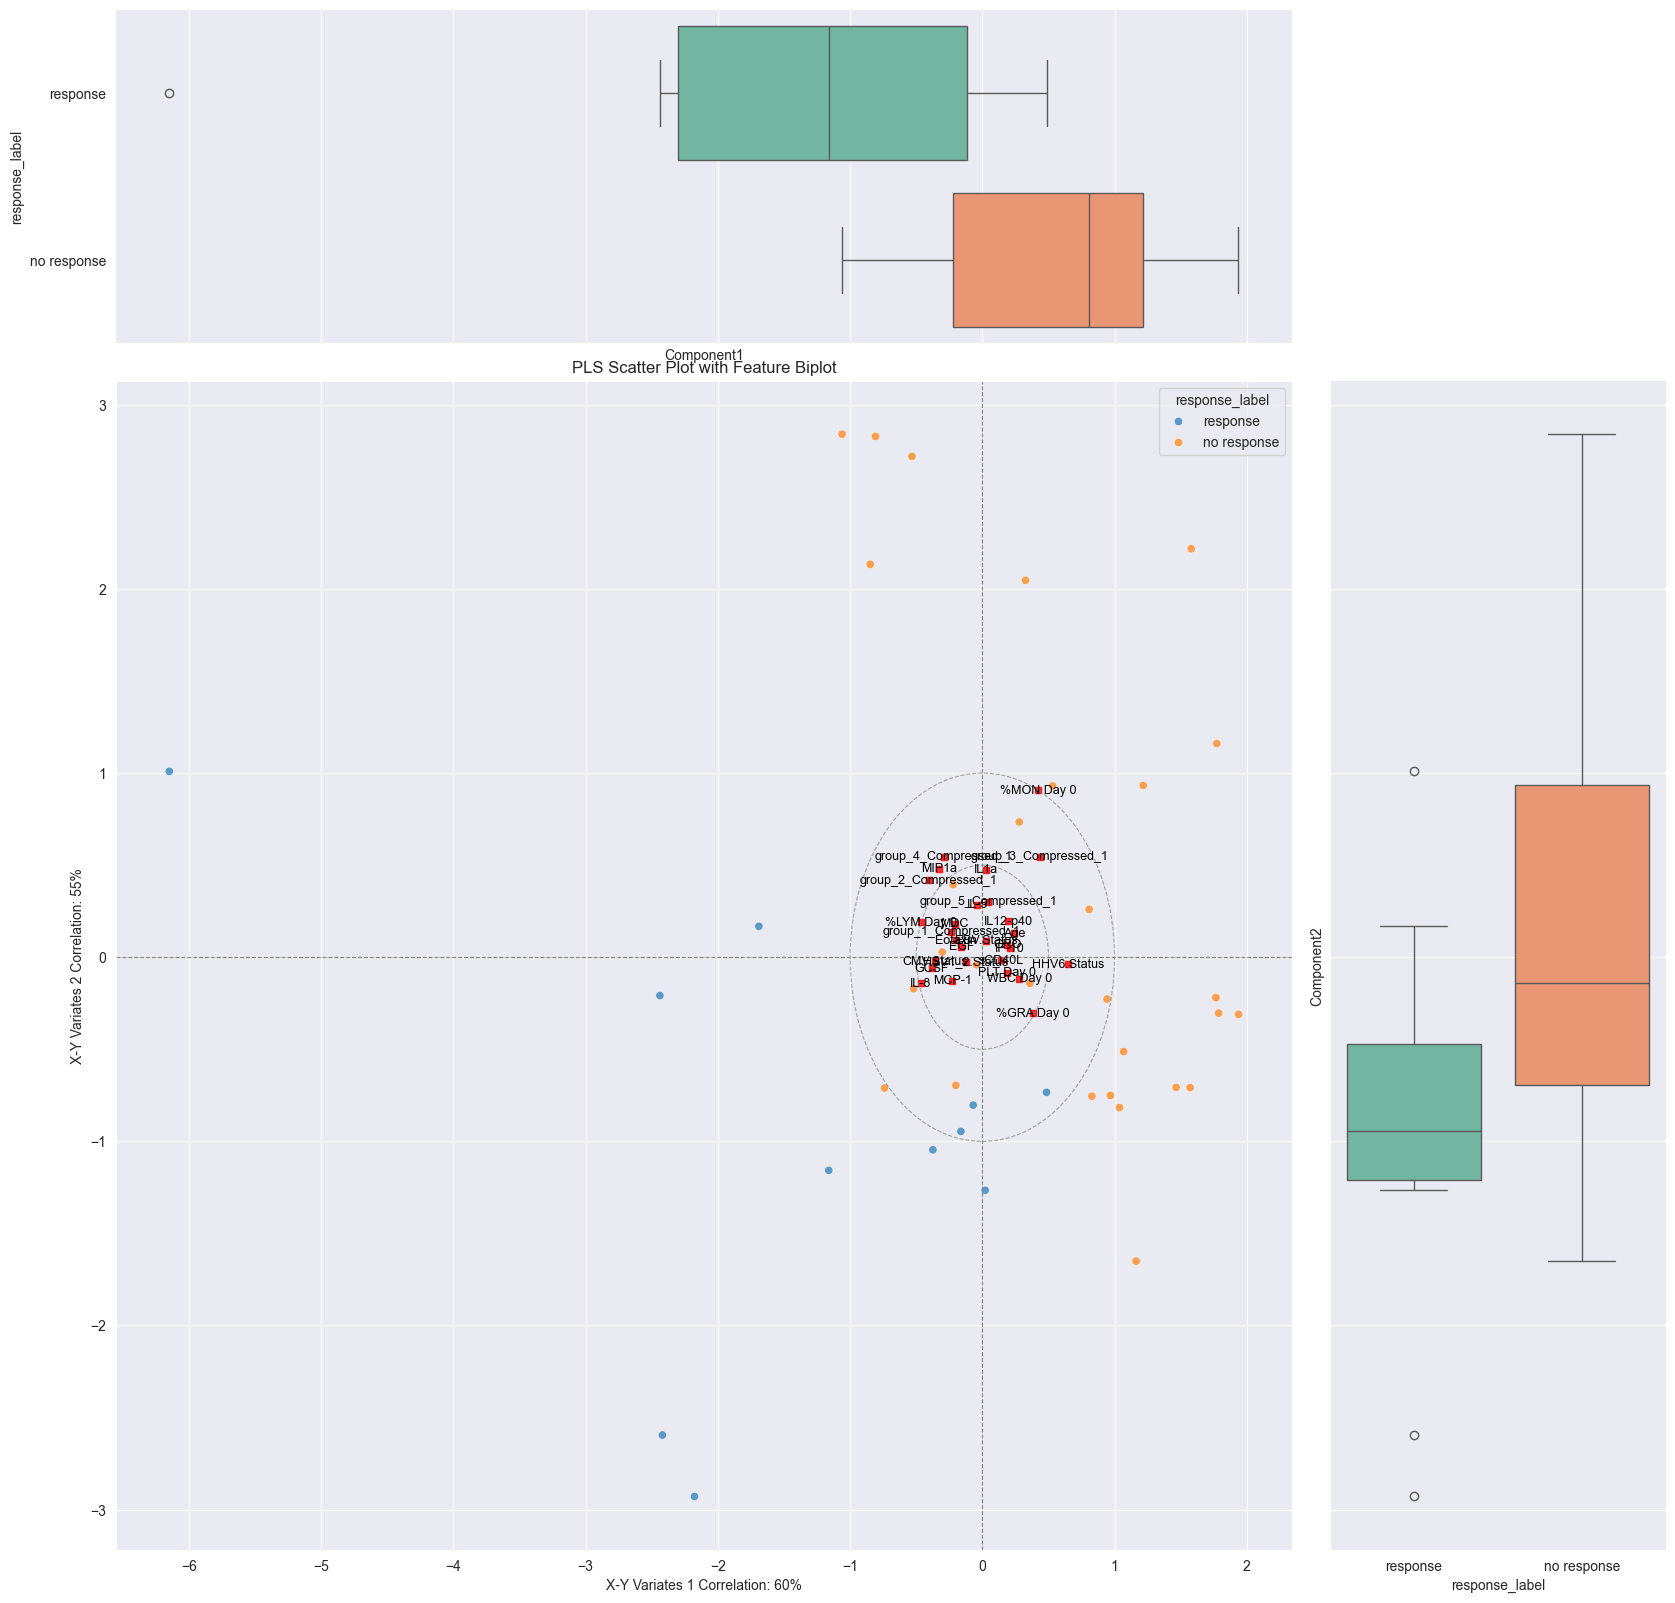

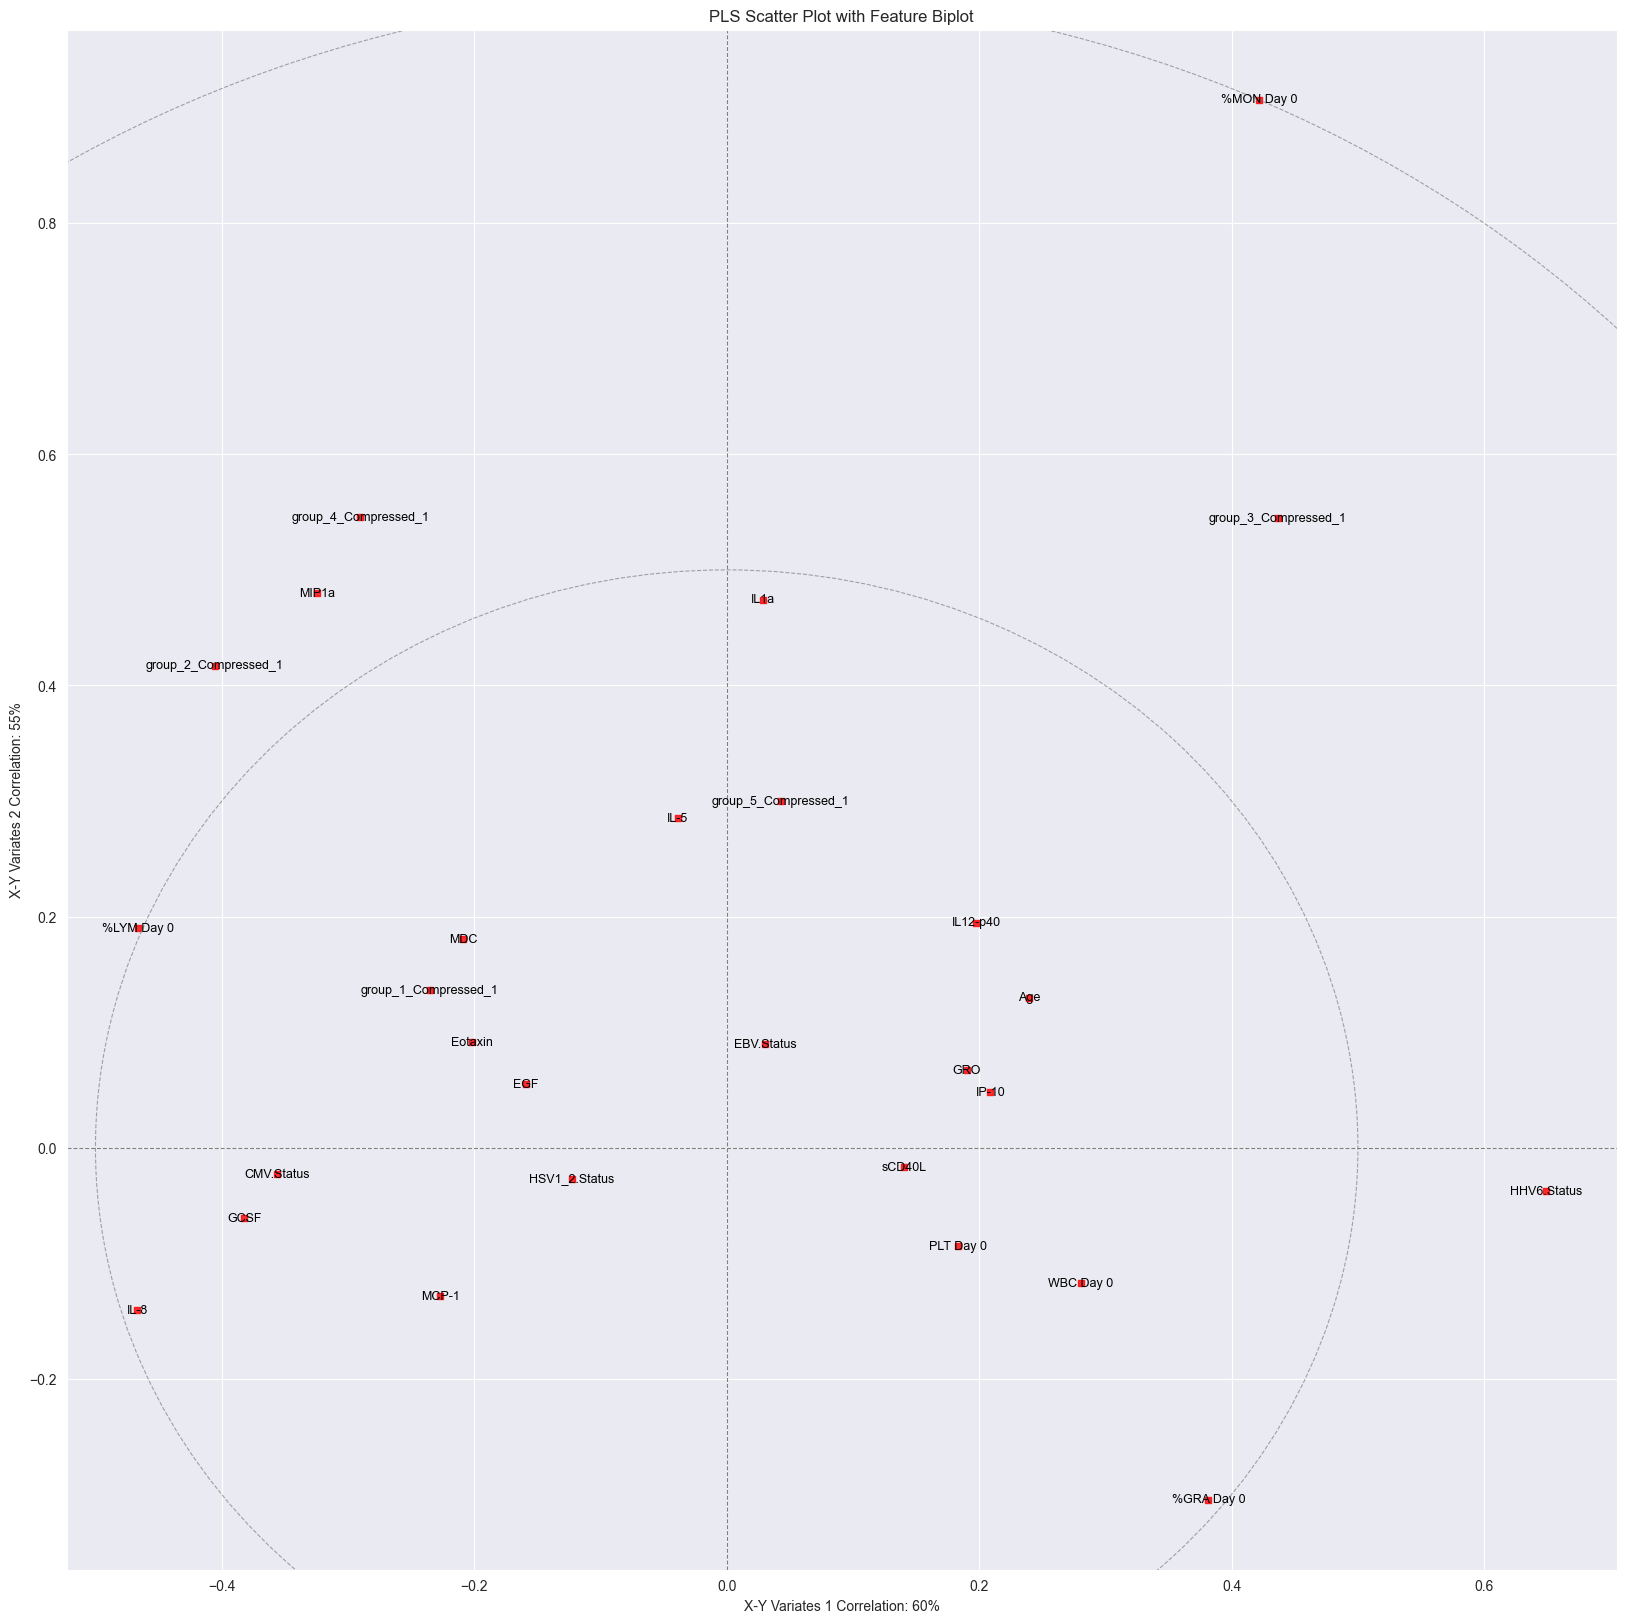

In [11]:
print(merged_data_compressed_correlated.columns)
plot_pls_with_response_marginals(
    data=merged_data_compressed_correlated.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    pc1_err_col=None,
    pc2_err_col=None,
    verbose=True,
)


plot_pls_only_contributions(
    data=merged_data_compressed_correlated.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
)

## Try different projection model

In [12]:
# https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2021.787574/full
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04054-2


def _add_reference_circles(ax, center, radii=[0.5, 1.0], color='gray', linestyle='--', linewidth=0.8, alpha=0.5):
    for radius in radii:
        circle = plt.Circle((center[0], center[1]), radius, color=color, fill=False, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
        ax.add_artist(circle)

def plot_umap_with_response_marginals(
    data, 
    numeric_features=None, 
    response_label_col='response_label', 
    excluded_features=[], 
    n_neighbors=15, 
    min_dist=0.1, 
    n_components=2,
    verbose=False
):
    """
    Plots a UMAP scatter plot with marginal boxplots grouped by response and non-response labels,
    and includes reference circles for visualizing feature separation.
    """
    # Select numeric features for UMAP
    if numeric_features is None:
        numeric_features = data.select_dtypes(include=[float, int]).columns.tolist()
        excluded_columns = [response_label_col, 'Vaccinee']
        excluded_columns.extend(excluded_features)
        numeric_features = [col for col in numeric_features if col not in excluded_columns]

    # Standardize the numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[numeric_features])
    
    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    umap_embedding = reducer.fit_transform(X_scaled)
    
    # Add UMAP components to the data
    for i in range(n_components):
        data[f"UMAP{i+1}"] = umap_embedding[:, i]
        
    # Compute feature contributions: Correlation of each feature with UMAP components
    feature_contributions = {}
    for i in range(n_components):
        umap_col = f"UMAP{i+1}"
        feature_contributions[umap_col] = {}
        for feature in numeric_features:
            corr = np.corrcoef(data[feature], data[umap_col])[0, 1]
            feature_contributions[umap_col][feature] = corr

    if verbose:
        print("\nFeature Contributions to UMAP Components:")
        for umap_col, contributions in feature_contributions.items():
            print(f"{umap_col}:")
            sorted_features = sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True)
            for feature, value in sorted_features:
                print(f"  {feature}: {value:.4f}")
    
    # Create the plot
    fig = plt.figure(figsize=(20, 20))
    gs = fig.add_gridspec(2, 2, width_ratios=(7, 2), height_ratios=(2, 7), wspace=0.05, hspace=0.05)
    ax_scatter = fig.add_subplot(gs[1, 0])
    ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
    ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

    # Scatter plot grouped by response labels
    scatter_kwargs = {'data': data, 'x': 'UMAP1', 'y': 'UMAP2', 'ax': ax_scatter, 'alpha': 0.7}
    scatter_kwargs['hue'] = response_label_col
    sns.scatterplot(**scatter_kwargs)
    
    
    # Calculate the centroid of the UMAP embedding
    umap1_center = (data['UMAP1'].max() + data['UMAP1'].min()) / 2
    umap2_center = (data['UMAP2'].max() + data['UMAP2'].min()) / 2
    
    visual_multiplier = 1  # Adjust as needed for scaling feature contributions
    
    # Plot feature contributions as squares around the new center
    for feature in numeric_features:
        umap1_corr = feature_contributions['UMAP1'][feature]
        umap2_corr = feature_contributions['UMAP2'][feature]
    
        # Adjust the plotting coordinates to be relative to the single center
        adjusted_umap1 = umap1_center + umap1_corr * visual_multiplier
        adjusted_umap2 = umap2_center + umap2_corr * visual_multiplier
    
        ax_scatter.scatter(
            adjusted_umap1, adjusted_umap2,
            color='red', alpha=0.8, marker='s', s=20, label=feature if verbose else None
        )
        ax_scatter.text(
            adjusted_umap1 * visual_multiplier, adjusted_umap2 * visual_multiplier,
            feature, color='black', fontsize=9, ha='center', va='center'
        )
    
    # Add reference circles centered around the single center
    _add_reference_circles(
        ax_scatter, 
        center=(umap1_center, umap2_center), 
        radii=[0.5 * visual_multiplier, 1.0 * visual_multiplier], 
        color='gray', linestyle='--', linewidth=0.8, alpha=0.7
    )
    ax_scatter.axhline(umap2_center, color='gray', linewidth=0.8, linestyle='--')
    ax_scatter.axvline(umap1_center, color='gray', linewidth=0.8, linestyle='--')

    # Marginal boxplots grouped by response labels
    sns.boxplot(
        data=data, 
        x='UMAP1', 
        y=response_label_col, 
        orient='h', 
        ax=ax_hist_x, 
        hue=response_label_col, 
        palette="Set2", 
        dodge=False
    )
    sns.boxplot(
        data=data, 
        x=response_label_col, 
        y='UMAP2', 
        orient='v', 
        ax=ax_hist_y, 
        hue=response_label_col, 
        palette="Set2", 
        dodge=False
    )

    # Hide labels on marginal plots for cleaner visualization
    ax_hist_x.tick_params(axis='x', labelbottom=False)
    ax_hist_y.tick_params(axis='y', labelleft=False)

    # Adjust subplot visibility
    ax_hist_x.spines['top'].set_visible(False)
    ax_hist_x.spines['right'].set_visible(False)
    ax_hist_x.spines['left'].set_visible(False)
    ax_hist_y.spines['top'].set_visible(False)
    ax_hist_y.spines['right'].set_visible(False)
    ax_hist_y.spines['bottom'].set_visible(False)

    # Axis labels and title
    ax_scatter.set_xlabel("UMAP1")
    ax_scatter.set_ylabel("UMAP2")
    ax_scatter.tick_params(axis='x', labelbottom=False)
    ax_scatter.tick_params(axis='y', labelleft=False)
    ax_scatter.set_title("UMAP Scatter Plot with Marginals")

    plt.show()



Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'GCSF', 'Flt3 Ligand', 'GM-CSF', 'Fractalkine', 'IFNa2', 'IFNg', 'GRO',
       'IL-10', 'MCP3', 'IL12-p40', 'MDC', 'IL12-p70', 'IL-13', 'IL-15',
       'sCD40L', 'IL17A', 'IL1Ra', 'IL1a', 'IL-9', 'IL-1b', 'IL-2', 'IL-5',
       'IL-6', 'IL-7', 'IL-8', 'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa',
       'TNFb', 'VEGF', 'WBC Day 0', 'RBC Day 0', 'HGB Day 0', 'HCT Day 0',
       'PLT Day 0', '%LYM Day 0', '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


/Users/eliasdams/School/Master 2/Thesis/Thesis/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Feature Contributions to UMAP Components:
UMAP1:
  MIP1b: -0.6824
  FGF-2: -0.5992
  IL-5: -0.5455
  IL1a: -0.5448
  IL1Ra: -0.5334
  MIP1a: -0.5309
  IL17A: -0.5285
  IFNg: -0.5185
  IL-13: -0.5119
  IL-6: -0.5107
  Flt3 Ligand: -0.4723
  GRO: 0.4696
  TGF-a: -0.4651
  MCP3: -0.4551
  IL-2: -0.4431
  RBC Day 0: -0.4383
  TNFa: -0.4377
  %GRA Day 0: 0.4262
  %LYM Day 0: -0.4241
  TNFb: -0.4181
  Fractalkine: -0.4157
  IL12-p70: -0.4001
  HCT Day 0: -0.3759
  Gender: -0.3739
  IFNa2: -0.3732
  IL-1b: -0.3686
  GCSF: -0.3543
  HGB Day 0: -0.3498
  GM-CSF: -0.3325
  IL-15: -0.3255
  MDC: -0.2803
  VEGF: -0.2744
  IL-9: -0.2685
  CMV.Status: -0.2654
  IL-10: -0.2594
  Age: 0.2529
  Eotaxin: -0.2505
  HHV6.Status: 0.2271
  PLT Day 0: 0.2099
  EGF: -0.1798
  %MON Day 0: -0.1597
  WBC Day 0: 0.1270
  EBV.Status: -0.1213
  MCP-1: -0.1180
  IL12-p40: -0.0954
  IP-10: 0.0931
  IL-7: -0.0584
  IL-8: -0.0559
  sCD40L: 0.0232
  HSV1_2.Status: 0.0060
UMAP2:
  Gender: 0.8036
  HCT Day 0: 0.7800
  HG

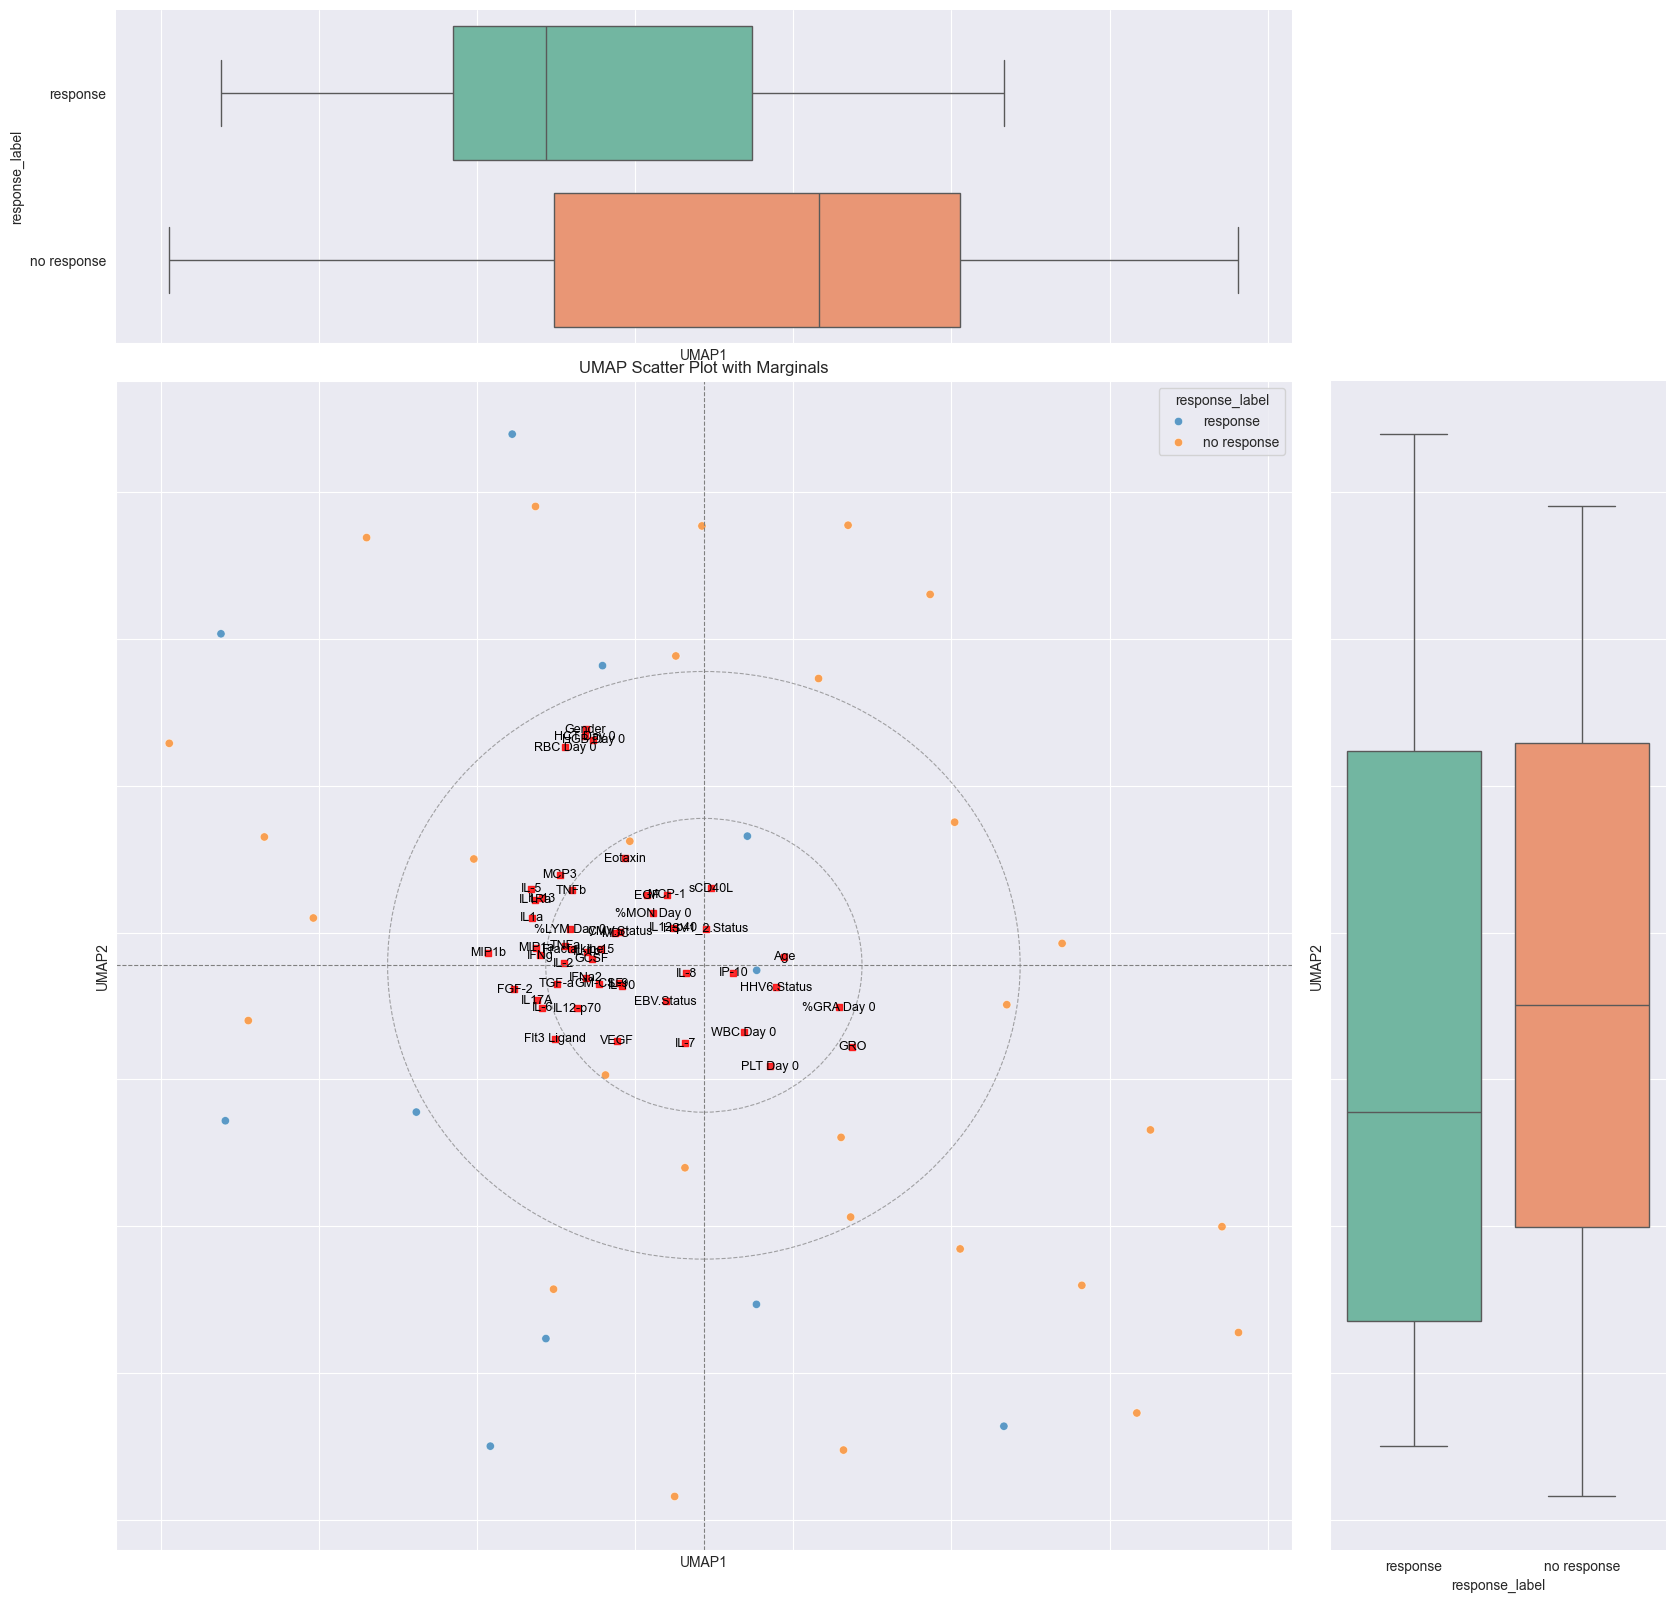

In [13]:
print(merged_data.columns)
plot_umap_with_response_marginals(
    data=merged_data.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    verbose=True,
)

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'FGF-2', 'Eotaxin', 'TGF-a',
       'Flt3 Ligand', 'IFNg', 'GRO', 'MDC', 'sCD40L', 'IL17A', 'IL1Ra', 'IL-8',
       'IP-10', 'MCP-1', 'MIP1a', 'MIP1b', 'TNFa', 'VEGF', 'WBC Day 0',
       'RBC Day 0', 'HGB Day 0', 'HCT Day 0', 'PLT Day 0', '%LYM Day 0',
       '%MON Day 0', '%GRA Day 0', 'Gender', 'Age'],
      dtype='object')


/Users/eliasdams/School/Master 2/Thesis/Thesis/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Feature Contributions to UMAP Components:
UMAP1:
  FGF-2: -0.6103
  TGF-a: -0.6071
  IL17A: -0.5693
  VEGF: -0.5641
  IFNg: -0.5482
  MIP1b: -0.5251
  TNFa: -0.4646
  IP-10: 0.3948
  MCP-1: 0.3794
  EBV.Status: -0.3519
  MIP1a: -0.3476
  Flt3 Ligand: -0.3240
  sCD40L: 0.3101
  PLT Day 0: -0.2988
  EGF: 0.2849
  %MON Day 0: -0.2776
  Eotaxin: 0.2542
  CMV.Status: -0.2324
  IL1Ra: -0.1670
  HHV6.Status: 0.1632
  HSV1_2.Status: -0.1554
  %GRA Day 0: 0.1490
  GRO: 0.1309
  MDC: 0.1302
  %LYM Day 0: -0.1144
  Age: 0.0880
  IL-8: -0.0859
  HCT Day 0: -0.0673
  WBC Day 0: 0.0559
  RBC Day 0: -0.0399
  HGB Day 0: -0.0363
  Gender: -0.0251
UMAP2:
  HCT Day 0: -0.8245
  HGB Day 0: -0.8203
  Gender: -0.8064
  RBC Day 0: -0.8031
  GRO: 0.5319
  IFNg: -0.3912
  PLT Day 0: 0.3598
  MIP1b: -0.3259
  TNFa: -0.3200
  Eotaxin: -0.2952
  FGF-2: -0.2891
  CMV.Status: -0.2665
  MIP1a: -0.2663
  IL17A: -0.2611
  IL1Ra: -0.2556
  %GRA Day 0: 0.2536
  TGF-a: -0.2527
  %LYM Day 0: -0.2354
  MDC: -0.2045
  %MO

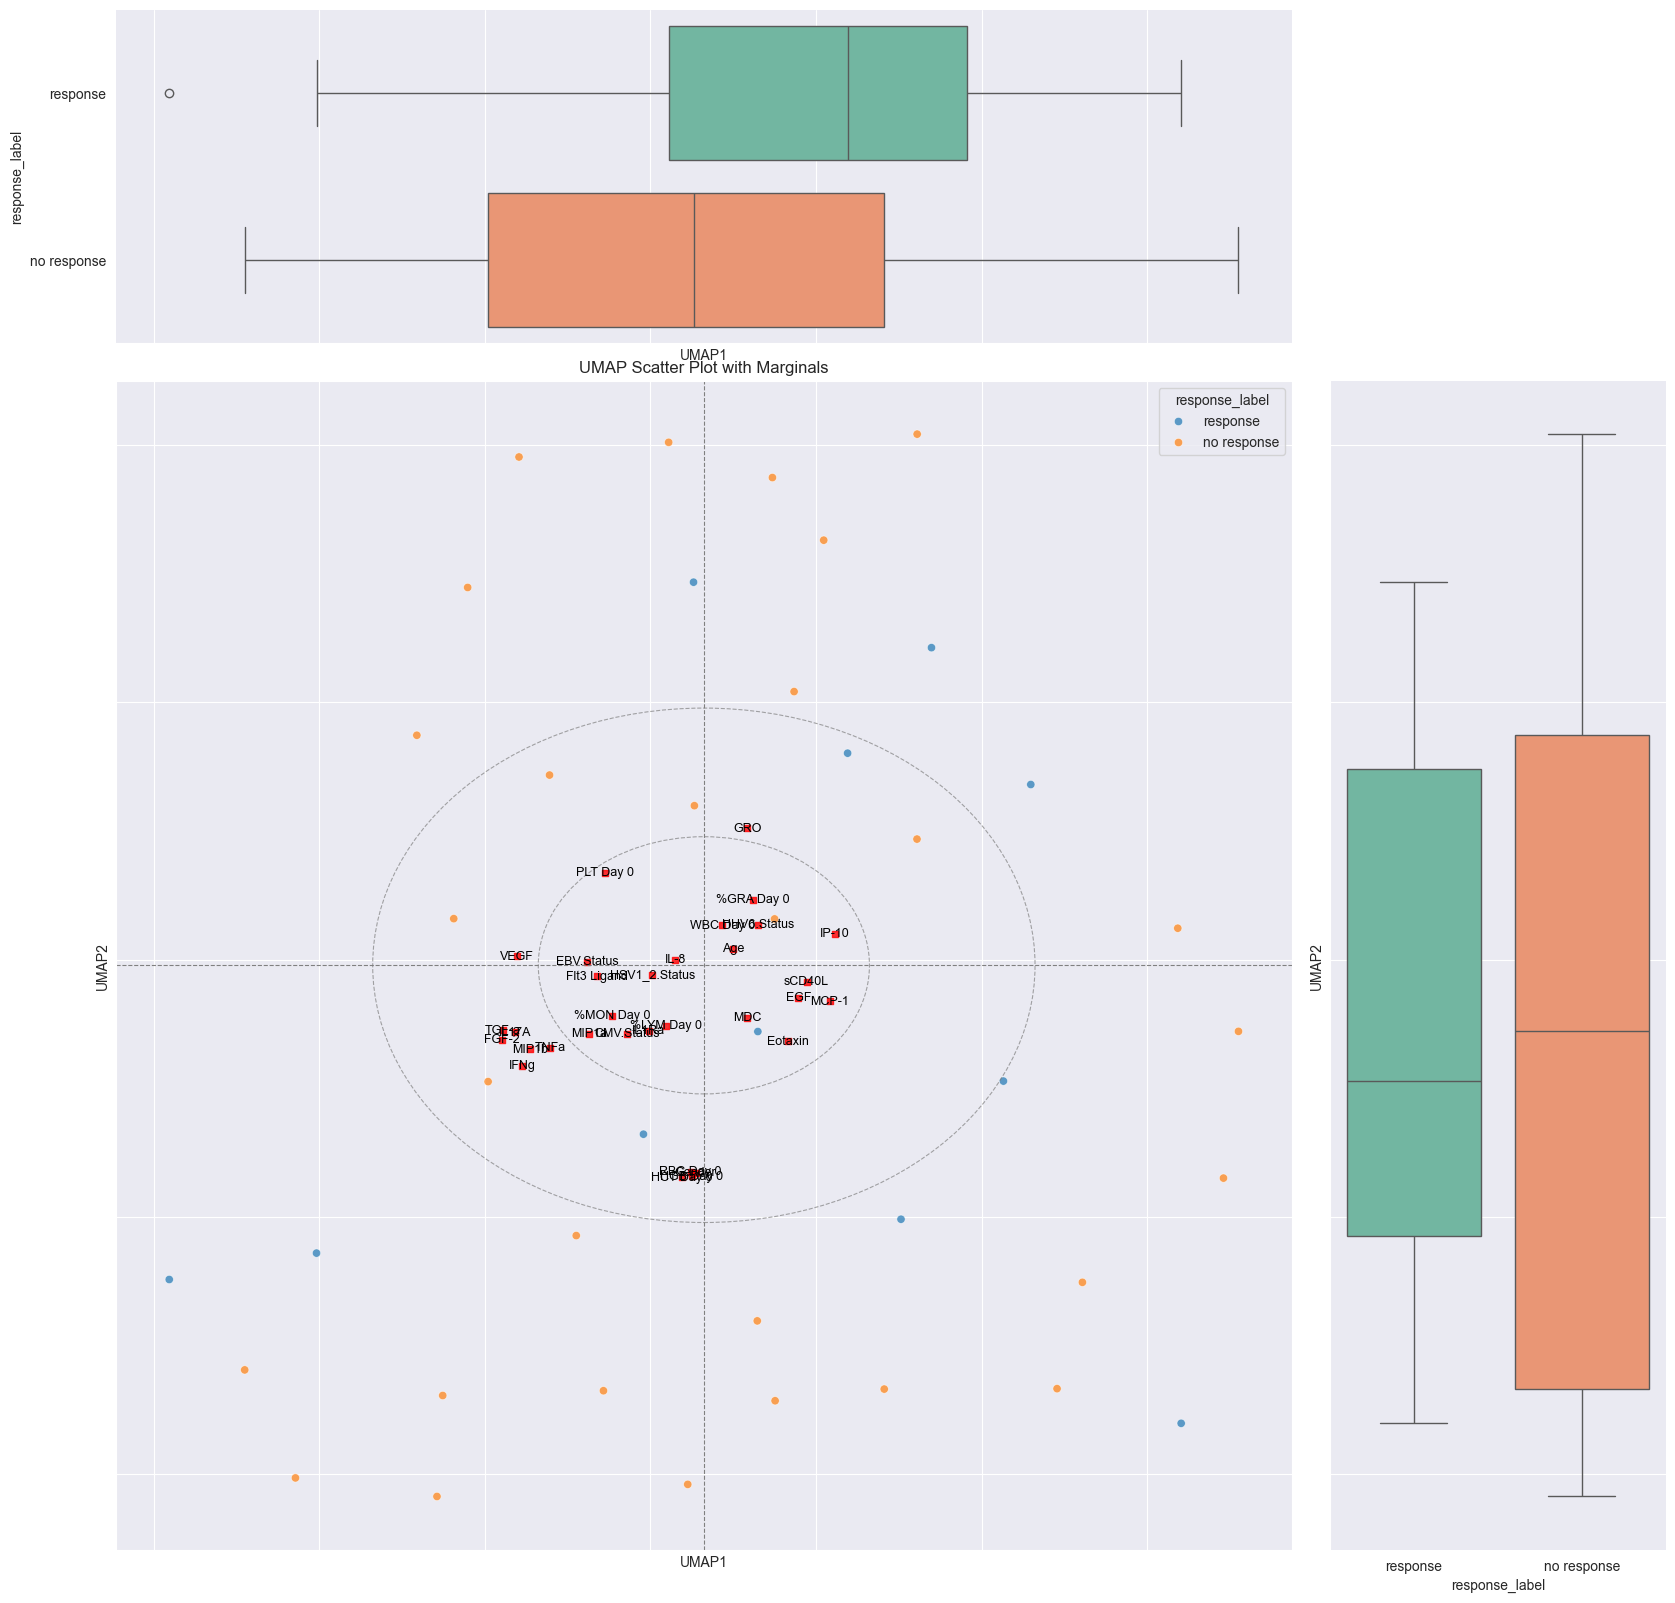

In [14]:
print(merged_data_less_cytokines.columns)
plot_umap_with_response_marginals(
    data=merged_data_less_cytokines.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    verbose=True,
)

Index(['Vaccinee', 'response_label', 'CMV.Status', 'EBV.Status',
       'HSV1_2.Status', 'HHV6.Status', 'EGF', 'Eotaxin', 'GCSF', 'GRO',
       'IL12-p40', 'MDC', 'sCD40L', 'IL1a', 'IL-5', 'IL-8', 'IP-10', 'MCP-1',
       'MIP1a', 'WBC Day 0', 'PLT Day 0', '%LYM Day 0', '%MON Day 0',
       '%GRA Day 0', 'Age', 'group_1_Compressed_1', 'group_2_Compressed_1',
       'group_3_Compressed_1', 'group_4_Compressed_1', 'group_5_Compressed_1'],
      dtype='object')


/Users/eliasdams/School/Master 2/Thesis/Thesis/.venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Feature Contributions to UMAP Components:
UMAP1:
  EGF: -0.6029
  MDC: -0.5721
  Eotaxin: -0.5596
  MCP-1: -0.4953
  EBV.Status: 0.3722
  MIP1a: -0.3656
  sCD40L: -0.3566
  group_1_Compressed_1: -0.3465
  IP-10: -0.3271
  IL-5: -0.3264
  %LYM Day 0: -0.3035
  %GRA Day 0: 0.2974
  group_3_Compressed_1: -0.2291
  PLT Day 0: 0.2283
  GCSF: -0.1730
  CMV.Status: 0.1560
  IL12-p40: 0.1468
  %MON Day 0: -0.1401
  GRO: -0.1399
  group_4_Compressed_1: -0.1388
  IL1a: -0.1238
  HHV6.Status: 0.1095
  group_5_Compressed_1: 0.1020
  WBC Day 0: 0.0790
  Age: 0.0663
  HSV1_2.Status: 0.0612
  group_2_Compressed_1: -0.0450
  IL-8: -0.0152
UMAP2:
  IL1a: -0.6319
  IL-5: -0.5644
  MIP1a: -0.5374
  %GRA Day 0: 0.5116
  %LYM Day 0: -0.5058
  group_4_Compressed_1: -0.4907
  GRO: 0.4629
  group_3_Compressed_1: -0.4521
  group_1_Compressed_1: -0.4513
  CMV.Status: -0.4224
  IP-10: 0.3282
  EBV.Status: -0.2872
  WBC Day 0: 0.2809
  IL12-p40: -0.2748
  %MON Day 0: -0.2294
  HHV6.Status: 0.2226
  GCSF: -0.2095

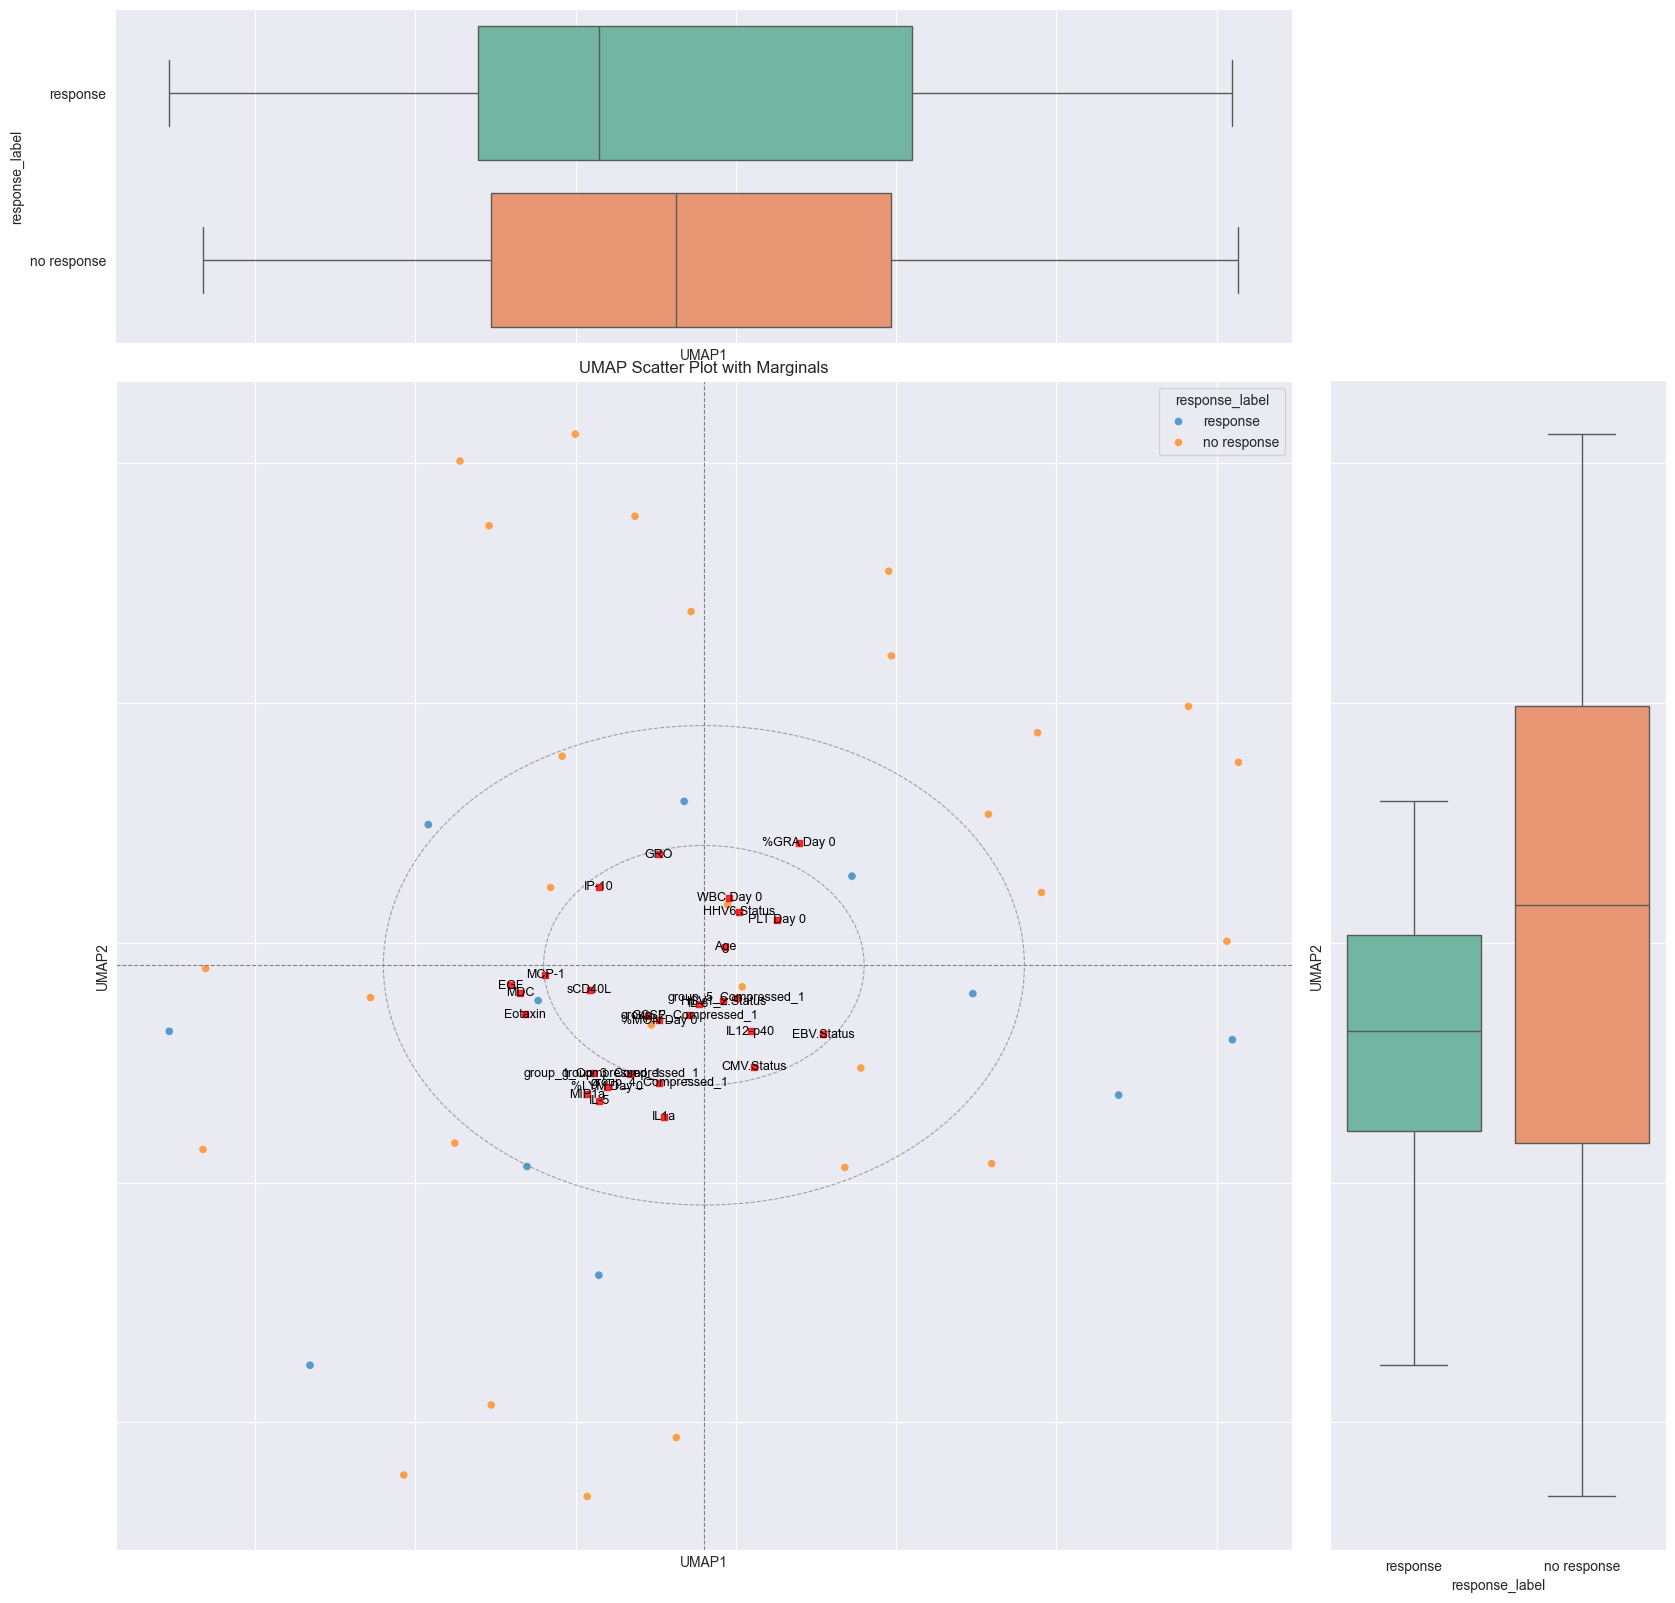

In [15]:
print(merged_data_compressed_correlated.columns)
plot_umap_with_response_marginals(
    data=merged_data_compressed_correlated.copy(), 
    numeric_features=None,  # Automatically selects numeric columns
    response_label_col='response_label',  # Color by response (response/no response)
    # excluded_features = ['CMV.Status', 'EBV.Status', 'HSV1_2.Status', 'HHV6.Status', 'Gender'],
    verbose=True,
)

### test features on Random Forest classifier with a balanced accuracy scoring metric


In [45]:

def evaluate_feature_sets(data, target_column='response_label', exclude_columns=['Vaccinee'], 
                         reduced_features=None, cv_folds=5, test_size=0.2, random_state=42):
    """
    Evaluate the performance of a Random Forest model using the full and reduced feature sets with cross-validation and a test split.
    """
    # Separate features and target
    X = data.drop(columns=[target_column] + exclude_columns)
    y = data[target_column]

    # Perform stratified train-test split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=y, 
        random_state=random_state
    )

    # Display the distribution of classes in the original, training, and test sets
    print("Original Dataset Class Distribution:")
    print(Counter(y))
    print("\nTraining Set Class Distribution:")
    print(Counter(y_train))
    print("\nTest Set Class Distribution:")
    print(Counter(y_test))
    print("-" * 50)

    # Define the balanced accuracy and regular accuracy scorers
    balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
    accuracy_scorer = make_scorer(accuracy_score)

    # Initialize Random Forest classifiers
    rf_full = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    rf_reduced = RandomForestClassifier(random_state=random_state, class_weight='balanced')

    results = {}

    # Set up stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # Cross-validation on the full feature set
    cv_bal_acc_full = cross_val_score(
        rf_full, X_train, y_train, 
        cv=skf, 
        scoring=balanced_accuracy_scorer
    ).mean()

    cv_acc_full = cross_val_score(
        rf_full, X_train, y_train, 
        cv=skf, 
        scoring=accuracy_scorer
    ).mean()

    results['Full Feature Set Mean CV Balanced Accuracy'] = cv_bal_acc_full
    results['Full Feature Set Mean CV Accuracy'] = cv_acc_full

    # Cross-validation on the reduced feature set, if provided
    if reduced_features:
        X_train_reduced = X_train[reduced_features]
        X_test_reduced = X_test[reduced_features]

        cv_bal_acc_reduced = cross_val_score(
            rf_reduced, X_train_reduced, y_train, 
            cv=skf, 
            scoring=balanced_accuracy_scorer
        ).mean()

        cv_acc_reduced = cross_val_score(
            rf_reduced, X_train_reduced, y_train, 
            cv=skf, 
            scoring=accuracy_scorer
        ).mean()

        results['Reduced Feature Set Mean CV Balanced Accuracy'] = cv_bal_acc_reduced
        results['Reduced Feature Set Mean CV Accuracy'] = cv_acc_reduced

    # Train the models on the entire training set
    rf_full.fit(X_train, y_train)
    if reduced_features:
        rf_reduced.fit(X_train_reduced, y_train)

    # Evaluate on the test set
    y_pred_full = rf_full.predict(X_test)
    results['Full Feature Set Test Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_full)
    results['Full Feature Set Test Accuracy'] = accuracy_score(y_test, y_pred_full)

    if reduced_features:
        y_pred_reduced = rf_reduced.predict(X_test_reduced)
        results['Reduced Feature Set Test Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_reduced)
        results['Reduced Feature Set Test Accuracy'] = accuracy_score(y_test, y_pred_reduced)

    # Check if predictions are only of one class for full feature set
    if len(set(y_pred_full)) == 1:
        results['Full Feature Set Single Class Prediction'] = True
        print("\nWarning: The Full Feature Set model is predicting only one class on the test set.")
    else:
        results['Full Feature Set Single Class Prediction'] = False

    # Check if predictions are only of one class for reduced feature set
    if reduced_features:
        if len(set(y_pred_reduced)) == 1:
            results['Reduced Feature Set Single Class Prediction'] = True
            print("Warning: The Reduced Feature Set model is predicting only one class on the test set.")
        else:
            results['Reduced Feature Set Single Class Prediction'] = False

    # Print results
    print("\nPerformance Metrics:")
    for key, value in results.items():
        if 'Single Class Prediction' in key:
            if value:
                print(f"{key}: Yes")
            else:
                print(f"{key}: No")
        else:
            print(f"{key}: {value:.4f}")

    return results

In [47]:
selected_features = ['HHV6.Status', 'IL-9', 'IL-8', 'HGB Day 0', '%LYM Day 0', 'FGF-2', 'TGF-a', 'TNFa', 'VEGF', '%MON Day 0']
results = evaluate_feature_sets(merged_data, reduced_features=selected_features)

Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------


Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.4550
Full Feature Set Mean CV Accuracy: 0.6524
Reduced Feature Set Mean CV Balanced Accuracy: 0.4550
Reduced Feature Set Mean CV Accuracy: 0.6524
Full Feature Set Test Balanced Accuracy: 0.5000
Full Feature Set Test Accuracy: 0.7500
Reduced Feature Set Test Balanced Accuracy: 0.5000
Reduced Feature Set Test Accuracy: 0.7500
Full Feature Set Single Class Prediction: Yes
Reduced Feature Set Single Class Prediction: Yes


In [39]:
selected_features = ['HHV6.Status', 'IL-8', 'HGB Day 0', '%LYM Day 0', 'FGF-2', 'TNFa', 'VEGF', '%MON Day 0']
results = evaluate_feature_sets(merged_data_less_cytokines, reduced_features=selected_features)

Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------


Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.4400
Full Feature Set Mean CV Accuracy: 0.6238
Reduced Feature Set Mean CV Balanced Accuracy: 0.4350
Reduced Feature Set Mean CV Accuracy: 0.6238
Full Feature Set Test Balanced Accuracy: 0.5000
Full Feature Set Test Accuracy: 0.7500
Reduced Feature Set Test Balanced Accuracy: 0.5000
Reduced Feature Set Test Accuracy: 0.7500
Full Feature Set Single Class Prediction: Yes
Reduced Feature Set Single Class Prediction: Yes


In [40]:
selected_features = ['HHV6.Status', 'IL-8', '%LYM Day 0', '%MON Day 0', 'group_3_Compressed_1', 'group_4_Compressed_1']
results = evaluate_feature_sets(merged_data_compressed_correlated, reduced_features=selected_features)

Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------


Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.4600
Full Feature Set Mean CV Accuracy: 0.6524
Reduced Feature Set Mean CV Balanced Accuracy: 0.4750
Reduced Feature Set Mean CV Accuracy: 0.6857
Full Feature Set Test Balanced Accuracy: 0.5000
Full Feature Set Test Accuracy: 0.7500
Reduced Feature Set Test Balanced Accuracy: 0.5000
Reduced Feature Set Test Accuracy: 0.7500
Full Feature Set Single Class Prediction: Yes
Reduced Feature Set Single Class Prediction: Yes


In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from collections import Counter

def evaluate_feature_sets_with_smote(data, target_column='response_label', exclude_columns=['Vaccinee'], 
                             reduced_features=None, cv_folds=5, test_size=0.2, random_state=42):
    """
    Evaluate the performance of a Random Forest model using the full and reduced feature sets with cross-validation and a test split,
    incorporating SMOTE to handle class imbalance.
    """
    # Separate features and target
    X = data.drop(columns=[target_column] + exclude_columns)
    y = data[target_column]
    
    # Perform stratified train-test split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=y, 
        random_state=random_state
    )
    
    # Display the distribution of classes in the original, training, and test sets
    print("Original Dataset Class Distribution:")
    print(Counter(y))
    print("\nTraining Set Class Distribution:")
    print(Counter(y_train))
    print("\nTest Set Class Distribution:")
    print(Counter(y_test))
    print("-" * 50)
    
    # Apply SMOTE to the training set
    smote = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print("After SMOTE, Training Set Class Distribution:")
    print(Counter(y_train_smote))
    print("-" * 50)
    
    # Define the balanced accuracy and regular accuracy scorers
    balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
    accuracy_scorer = make_scorer(accuracy_score)
    
    # Initialize Random Forest classifiers
    rf_full = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    rf_reduced = RandomForestClassifier(random_state=random_state, class_weight='balanced')
    
    results = {}
    
    # Set up stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Cross-validation on the full feature set with SMOTE
    cv_bal_acc_full = cross_val_score(
        rf_full, X_train_smote, y_train_smote, 
        cv=skf, 
        scoring=balanced_accuracy_scorer
    ).mean()
    
    cv_acc_full = cross_val_score(
        rf_full, X_train_smote, y_train_smote, 
        cv=skf, 
        scoring=accuracy_scorer
    ).mean()
    
    results['Full Feature Set Mean CV Balanced Accuracy'] = cv_bal_acc_full
    results['Full Feature Set Mean CV Accuracy'] = cv_acc_full
    
    # Cross-validation on the reduced feature set, if provided
    if reduced_features:
        X_train_reduced = X_train_smote[reduced_features]
        X_test_reduced = X_test[reduced_features]
        
        cv_bal_acc_reduced = cross_val_score(
            rf_reduced, X_train_reduced, y_train_smote, 
            cv=skf, 
            scoring=balanced_accuracy_scorer
        ).mean()
        
        cv_acc_reduced = cross_val_score(
            rf_reduced, X_train_reduced, y_train_smote, 
            cv=skf, 
            scoring=accuracy_scorer
        ).mean()
        
        results['Reduced Feature Set Mean CV Balanced Accuracy'] = cv_bal_acc_reduced
        results['Reduced Feature Set Mean CV Accuracy'] = cv_acc_reduced
    
    # Train the models on the entire training set with SMOTE
    rf_full.fit(X_train_smote, y_train_smote)
    if reduced_features:
        rf_reduced.fit(X_train_reduced, y_train_smote)
    
    # Evaluate on the test set
    y_pred_full = rf_full.predict(X_test)
    results['Full Feature Set Test Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_full)
    results['Full Feature Set Test Accuracy'] = accuracy_score(y_test, y_pred_full)
    
    if reduced_features:
        y_pred_reduced = rf_reduced.predict(X_test_reduced)
        results['Reduced Feature Set Test Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred_reduced)
        results['Reduced Feature Set Test Accuracy'] = accuracy_score(y_test, y_pred_reduced)
    
    # Check if predictions are only of one class for full feature set
    if len(set(y_pred_full)) == 1:
        results['Full Feature Set Single Class Prediction'] = True
        print("\nWarning: The Full Feature Set model is predicting only one class on the test set.")
    else:
        results['Full Feature Set Single Class Prediction'] = False
    
    # Check if predictions are only of one class for reduced feature set
    if reduced_features:
        if len(set(y_pred_reduced)) == 1:
            results['Reduced Feature Set Single Class Prediction'] = True
            print("Warning: The Reduced Feature Set model is predicting only one class on the test set.")
        else:
            results['Reduced Feature Set Single Class Prediction'] = False
    
    # Print results
    print("\nPerformance Metrics:")
    for key, value in results.items():
        if 'Single Class Prediction' in key:
            if value:
                print(f"{key}: Yes")
            else:
                print(f"{key}: No")
        else:
            print(f"{key}: {value:.4f}")
    
    return results

In [42]:
selected_features = ['HHV6.Status', 'IL-9', 'IL-8', 'HGB Day 0', '%LYM Day 0', 'FGF-2', 'TGF-a', 'TNFa', 'VEGF', '%MON Day 0']
results = evaluate_feature_sets_with_smote(merged_data, reduced_features=selected_features)

Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------
After SMOTE, Training Set Class Distribution:
Counter({'response': 23, 'no response': 23})
--------------------------------------------------


Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.7250
Full Feature Set Mean CV Accuracy: 0.7156
Reduced Feature Set Mean CV Balanced Accuracy: 0.9150
Reduced Feature Set Mean CV Accuracy: 0.9133
Full Feature Set Test Balanced Accuracy: 0.5000
Full Feature Set Test Accuracy: 0.7500
Reduced Feature Set Test Balanced Accuracy: 0.7500
Reduced Feature Set Test Accuracy: 0.8750
Full Feature Set Single Class Prediction: Yes
Reduced Feature Set Single Class Prediction: No


In [43]:
selected_features = ['HHV6.Status', 'IL-8', 'HGB Day 0', '%LYM Day 0', 'FGF-2', 'TNFa', 'VEGF', '%MON Day 0']
results = evaluate_feature_sets_with_smote(merged_data_less_cytokines, reduced_features=selected_features)

Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------
After SMOTE, Training Set Class Distribution:
Counter({'response': 23, 'no response': 23})
--------------------------------------------------

Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.7500
Full Feature Set Mean CV Accuracy: 0.7378
Reduced Feature Set Mean CV Balanced Accuracy: 0.8700
Reduced Feature Set Mean CV Accuracy: 0.8689
Full Feature Set Test Balanced Accuracy: 0.6667
Full Feature Set Test Accuracy: 0.7500
Reduced Feature Set Test Balanced Accuracy: 0.6667
Reduced Feature Set Test Accuracy: 0.7500
Full Feature Set Single Class Prediction: No
Reduced Feature Set Single Class Prediction: No


In [44]:
selected_features = ['HHV6.Status', 'IL-8', '%LYM Day 0', '%MON Day 0', 'group_3_Compressed_1', 'group_4_Compressed_1']
results = evaluate_feature_sets_with_smote(merged_data_compressed_correlated, reduced_features=selected_features)

Original Dataset Class Distribution:
Counter({'no response': 29, 'response': 11})

Training Set Class Distribution:
Counter({'no response': 23, 'response': 9})

Test Set Class Distribution:
Counter({'no response': 6, 'response': 2})
--------------------------------------------------
After SMOTE, Training Set Class Distribution:
Counter({'response': 23, 'no response': 23})
--------------------------------------------------

Performance Metrics:
Full Feature Set Mean CV Balanced Accuracy: 0.8900
Full Feature Set Mean CV Accuracy: 0.8911
Reduced Feature Set Mean CV Balanced Accuracy: 0.8400
Reduced Feature Set Mean CV Accuracy: 0.8289
Full Feature Set Test Balanced Accuracy: 0.4167
Full Feature Set Test Accuracy: 0.6250
Reduced Feature Set Test Balanced Accuracy: 0.7500
Reduced Feature Set Test Accuracy: 0.8750
Full Feature Set Single Class Prediction: No
Reduced Feature Set Single Class Prediction: No
